In [ ]:
# Cell 1
"""
FIGURE NOTEBOOK - Cell 1: File Verification
Check that required files exist for OTC subjects
"""

import pandas as pd
from pathlib import Path

# Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')

COPE_MAP = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

# Load subject info
df = pd.read_csv(CSV_FILE)
otc_df = df[(df['patient'] == 1) & (df['group'] == 'OTC')]

print("OTC SUBJECTS FILE CHECK")
print("=" * 70)

for _, row in otc_df.iterrows():
    subject_id = row['sub']
    hemi = 'l' if row['intact_hemi'] == 'left' else 'r'
    
    subj_dir = BASE_DIR / subject_id
    if not subj_dir.exists():
        print(f"\n❌ {subject_id}: directory not found")
        continue
    
    # Find sessions
    sessions = sorted([s.name.replace('ses-', '') for s in subj_dir.glob('ses-*') if s.is_dir()])
    start = SESSION_START.get(subject_id, 1)
    sessions = [s for s in sessions if int(s) >= start]
    
    if len(sessions) < 2:
        print(f"\n⚠️  {subject_id}: only {len(sessions)} session(s), need 2+ for longitudinal")
        continue
    
    print(f"\n✓ {subject_id} (hemi={hemi}, sessions={sessions})")
    
    first_session = sessions[0]
    
    # Check ROI masks
    print(f"  ROI masks (ses-{first_session}):")
    for category in COPE_MAP.keys():
        mask_file = subj_dir / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        status = "✓" if mask_file.exists() else "❌"
        print(f"    {status} {category}: {mask_file.name}")
    
    # Check zstat files per session
    print(f"  Zstat files:")
    for session in sessions:
        feat_dir = subj_dir / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
        
        missing = []
        for category, cope_num in COPE_MAP.items():
            if session == first_session:
                zstat_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            else:
                zstat_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / f'zstat1_ses{first_session}.nii.gz'
            
            if not zstat_file.exists():
                missing.append(category)
        
        if missing:
            print(f"    ses-{session}: ❌ missing {missing}")
        else:
            print(f"    ses-{session}: ✓ all 4 categories")

print("\n" + "=" * 70)
print("Ready to proceed if all OTC subjects show ✓")

OTC SUBJECTS FILE CHECK

✓ sub-004 (hemi=l, sessions=['01', '02', '03', '05', '06', '07'])
  ROI masks (ses-01):
    ✓ face: l_face_searchmask.nii.gz
    ✓ word: l_word_searchmask.nii.gz
    ✓ object: l_object_searchmask.nii.gz
    ✓ house: l_house_searchmask.nii.gz
  Zstat files:
    ses-01: ✓ all 4 categories
    ses-02: ✓ all 4 categories
    ses-03: ✓ all 4 categories
    ses-05: ✓ all 4 categories
    ses-06: ✓ all 4 categories
    ses-07: ❌ missing ['face', 'word', 'object', 'house']

✓ sub-008 (hemi=l, sessions=['01', '02'])
  ROI masks (ses-01):
    ✓ face: l_face_searchmask.nii.gz
    ✓ word: l_word_searchmask.nii.gz
    ✓ object: l_object_searchmask.nii.gz
    ✓ house: l_house_searchmask.nii.gz
  Zstat files:
    ses-01: ✓ all 4 categories
    ses-02: ✓ all 4 categories

✓ sub-010 (hemi=r, sessions=['02', '03'])
  ROI masks (ses-02):
    ✓ face: r_face_searchmask.nii.gz
    ✓ word: r_word_searchmask.nii.gz
    ✓ object: r_object_searchmask.nii.gz
    ✓ house: r_house_searchma

In [23]:
# Cell 2
"""
FIGURE NOTEBOOK - Cell 2: Imports and Helper Functions
"""

import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, label
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
OUTPUT_DIR = BASE_DIR / "analyses" / "figures"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

COPE_MAP = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

CATEGORY_COLORS = {
    'face': '#E91E63',
    'word': '#FF9800',
    'object': '#00BCD4',
    'house': '#4CAF50'
}

CATEGORY_TYPE = {
    'face': 'Unilateral',
    'word': 'Unilateral', 
    'object': 'Bilateral',
    'house': 'Bilateral'
}


def load_otc_subjects():
    """Load OTC subject info from CSV"""
    df = pd.read_csv(CSV_FILE)
    otc_df = df[(df['patient'] == 1) & (df['group'] == 'OTC')]
    
    subjects = {}
    for _, row in otc_df.iterrows():
        subject_id = row['sub']
        subj_dir = BASE_DIR / subject_id
        
        if not subj_dir.exists():
            continue
        
        sessions = sorted([s.name.replace('ses-', '') for s in subj_dir.glob('ses-*') if s.is_dir()])
        start = SESSION_START.get(subject_id, 1)
        sessions = [s for s in sessions if int(s) >= start]
        
        if len(sessions) < 2:
            continue
        
        hemi = 'l' if row['intact_hemi'] == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"OTC{subject_id.split('-')[1]}",
            'sessions': sessions,
            'hemi': hemi,
            'age_1': row['age_1']
        }
    
    return subjects


def create_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create 6mm sphere around peak - matching RSA pipeline"""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), 
        np.arange(brain_shape[1]), 
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def get_roi_sphere(subject_id, session, category, hemi, threshold_z=2.3, radius=6):
    """
    Match main analysis: centroid-based sphere, return betas
    """
    
    # Get first session for this subject
    first_session = SESSION_START.get(subject_id, 1)
    first_session = str(first_session).zfill(2)
    
    # Mask is ALWAYS in first session folder
    mask_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
    if not mask_file.exists():
        return None, None, None, None
    
    mask_img = nib.load(mask_file)
    mask = mask_img.get_fdata() > 0
    affine = mask_img.affine
    brain_shape = mask_img.shape
    
    # Zstat for ROI definition (same as main analysis)
    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    cope_num = COPE_MAP[category]
    
    if session == first_session:
        zstat_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
        beta_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
    else:
        zstat_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / f'zstat1_ses{first_session}.nii.gz'
        beta_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / f'cope1_ses{first_session}.nii.gz'
    
    if not zstat_file.exists() or not beta_file.exists():
        return None, None, None, None
    
    zstat = nib.load(zstat_file).get_fdata()
    betas = nib.load(beta_file).get_fdata()
    
    # Threshold and find largest cluster
    suprathresh = (zstat > threshold_z) & mask
    
    if suprathresh.sum() < 50:
        return None, None, None, None
    
    labeled, n_clusters = label(suprathresh)
    if n_clusters == 0:
        return None, None, None, None
    
    cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
    largest_idx = np.argmax(cluster_sizes) + 1
    cluster_mask = (labeled == largest_idx)
    
    # CENTROID (not peak) - matches main analysis
    centroid = nib.affines.apply_affine(affine, center_of_mass(cluster_mask))
    
    # Create 6mm sphere around CENTROID
    sphere_mask = create_sphere(centroid, affine, brain_shape, radius=radius)
    
    return sphere_mask, betas, affine, centroid

# Load subjects
OTC_SUBJECTS = load_otc_subjects()
print(f"✓ Loaded {len(OTC_SUBJECTS)} OTC subjects:")
for sid, info in OTC_SUBJECTS.items():
    print(f"  {info['code']}: sessions {info['sessions']}, hemi={info['hemi']}")

✓ Loaded 6 OTC subjects:
  OTC004: sessions ['01', '02', '03', '05', '06', '07'], hemi=l
  OTC008: sessions ['01', '02'], hemi=l
  OTC010: sessions ['02', '03'], hemi=r
  OTC017: sessions ['01', '02', '03', '04'], hemi=r
  OTC021: sessions ['01', '02', '03'], hemi=r
  OTC079: sessions ['01', '02'], hemi=r


Testing Liu distinctiveness visualization...
  Auto-selected sessions: 01 → 06


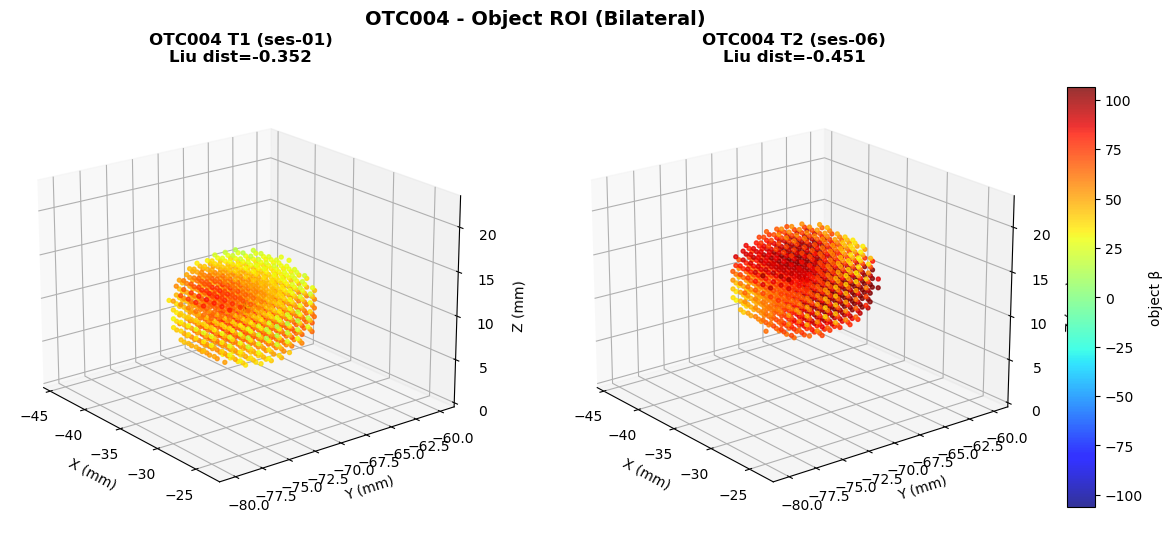


  OTC004 object (Bilateral):
    ses-01: centroid=[-33.1 -71.   10.7], n=905, Liu=-0.352
    ses-06: centroid=[-34.8 -69.1  12.5], n=904, Liu=-0.451

  METRICS (should match CSV):
    Liu T1: -0.352
    Liu T2: -0.451
    Selectivity_Change: |-0.451 - -0.352| = 0.099
    Spatial drift: 3.2 mm


In [27]:
# Cell 3
"""
FIGURE NOTEBOOK - Cell 3: Liu Distinctiveness Visualization
Shows correlation-based selectivity (matches main analysis exactly)
"""

from scipy.ndimage import center_of_mass, label

def get_roi_data_liu(subject_id, session, category, hemi, threshold_z=2.3, radius=6):
    """
    Extract sphere data and compute Liu distinctiveness
    Returns betas for all 4 categories to compute distinctiveness
    """
    
    first_session = SESSION_START.get(subject_id, 1)
    first_session = str(first_session).zfill(2)
    
    # Mask from first session
    mask_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
    if not mask_file.exists():
        return None
    
    mask_img = nib.load(mask_file)
    mask = mask_img.get_fdata() > 0
    affine = mask_img.affine
    brain_shape = mask_img.shape
    
    # Zstat for ROI definition
    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    cope_num = COPE_MAP[category]
    
    if session == first_session:
        zstat_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
    else:
        zstat_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / f'zstat1_ses{first_session}.nii.gz'
    
    if not zstat_file.exists():
        return None
    
    zstat = nib.load(zstat_file).get_fdata()
    
    # Find largest cluster and centroid
    suprathresh = (zstat > threshold_z) & mask
    if suprathresh.sum() < 50:
        return None
    
    labeled, n_clusters = label(suprathresh)
    if n_clusters == 0:
        return None
    
    cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
    largest_idx = np.argmax(cluster_sizes) + 1
    cluster_mask = (labeled == largest_idx)
    
    centroid = nib.affines.apply_affine(affine, center_of_mass(cluster_mask))
    sphere_mask = create_sphere(centroid, affine, brain_shape, radius=radius)
    
    # Get voxel coordinates
    voxel_indices = np.where(sphere_mask)
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(affine, voxel_coords)
    
    # Extract betas for ALL 4 categories
    beta_patterns = {}
    for cat, cope_n in COPE_MAP.items():
        if session == first_session:
            beta_file = feat_dir / f'cope{cope_n}.feat' / 'stats' / 'cope1.nii.gz'
        else:
            beta_file = feat_dir / f'cope{cope_n}.feat' / 'stats' / f'cope1_ses{first_session}.nii.gz'
        
        if not beta_file.exists():
            return None
        
        beta_data = nib.load(beta_file).get_fdata()
        beta_patterns[cat] = beta_data[sphere_mask]
    
    # Compute Liu distinctiveness (Fisher-transformed)
    preferred = beta_patterns[category]
    non_preferred = [beta_patterns[c] for c in COPE_MAP.keys() if c != category]
    
    correlations = []
    for np_pattern in non_preferred:
        r, _ = pearsonr(preferred, np_pattern)
        r_fisher = np.arctanh(np.clip(r, -0.999, 0.999))
        correlations.append(r_fisher)
    
    liu_distinctiveness = np.mean(correlations)
    
    return {
        'world_coords': world_coords,
        'preferred_betas': preferred,
        'centroid': centroid,
        'n_voxels': len(preferred),
        'liu_distinctiveness': liu_distinctiveness,
        'correlations': correlations,
        'mean_beta': np.mean(preferred)
    }


def visualize_liu_distinctiveness(subject_id, category, sessions_to_plot=None, radius=6, save=False):
    """
    Visualize ROI with Liu distinctiveness calculation
    Shows preferred category betas colored by magnitude
    Reports Liu distinctiveness (correlation-based) - matches main analysis
    """
    
    if subject_id not in OTC_SUBJECTS:
        print(f"❌ {subject_id} not found")
        return
    
    info = OTC_SUBJECTS[subject_id]
    code = info['code']
    hemi = info['hemi']
    sessions = info['sessions']
    
    # Find valid sessions
    if sessions_to_plot is None:
        valid_sessions = []
        for ses in sessions:
            data = get_roi_data_liu(subject_id, ses, category, hemi, radius=radius)
            if data is not None:
                valid_sessions.append(ses)
        
        if len(valid_sessions) < 2:
            print(f"❌ {code} {category}: only {len(valid_sessions)} valid session(s)")
            return
        
        sessions_to_plot = [valid_sessions[0], valid_sessions[-1]]
        print(f"  Auto-selected sessions: {sessions_to_plot[0]} → {sessions_to_plot[-1]}")
    
    # Collect data
    session_data = {}
    final_sessions = []
    
    for ses in sessions_to_plot:
        data = get_roi_data_liu(subject_id, ses, category, hemi, radius=radius)
        
        if data is None:
            print(f"  ⚠️  {code} ses-{ses} {category}: no valid ROI")
            continue
        
        session_data[ses] = data
        final_sessions.append(ses)
    
    if len(final_sessions) < 2:
        print(f"❌ {code} {category}: need at least 2 valid sessions")
        return
    
    # Compute shared axis limits
    all_coords = np.vstack([session_data[s]['world_coords'] for s in final_sessions])
    x_lim = [all_coords[:,0].min() - 5, all_coords[:,0].max() + 5]
    y_lim = [all_coords[:,1].min() - 5, all_coords[:,1].max() + 5]
    z_lim = [all_coords[:,2].min() - 5, all_coords[:,2].max() + 5]
    
    # Liu-style colorbar: fixed range for z-stats/betas
    # Using percentile-based for betas
    all_betas = np.concatenate([session_data[s]['preferred_betas'] for s in final_sessions])
    vmax = np.percentile(np.abs(all_betas), 95)
    vmin = -vmax
    
    # Create figure
    n_sessions = len(final_sessions)
    fig = plt.figure(figsize=(6 * n_sessions + 2, 6))
    
    view = (20, 175) if hemi == 'r' else (20, 322)
    
    for i, ses in enumerate(final_sessions):
        data = session_data[ses]
        coords = data['world_coords']
        betas = data['preferred_betas']
        centroid = data['centroid']
        liu = data['liu_distinctiveness']
        
        ax = fig.add_subplot(1, n_sessions, i + 1, projection='3d')
        
        # Liu uses 'jet' colormap
        scatter = ax.scatter(
            coords[:, 0], coords[:, 1], coords[:, 2],
            c=betas, s=8, marker='o',
            cmap='jet', vmin=vmin, vmax=vmax, alpha=0.8
        )
        
        # Mark centroid
        ax.scatter([centroid[0]], [centroid[1]], [centroid[2]], 
                   c='black', s=80, marker='+', linewidths=2)
        
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_zlim(z_lim)
        
        ax.set_xlabel('X (mm)', fontsize=10)
        ax.set_ylabel('Y (mm)', fontsize=10)
        ax.set_zlabel('Z (mm)', fontsize=10)
        
        session_label = f"T{i+1} (ses-{ses})"
        ax.set_title(f'{code} {session_label}\nLiu dist={liu:.3f}', 
                     fontsize=12, fontweight='bold')
        
        ax.view_init(elev=view[0], azim=view[1])
        ax.grid(True, alpha=0.3)
    
    # Colorbar (Liu style)
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label(f'{category} β', fontsize=10)
    
    # Suptitle with category type
    cat_type = CATEGORY_TYPE[category]
    fig.suptitle(f'{code} - {category.capitalize()} ROI ({cat_type})', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    if save:
        save_path = OUTPUT_DIR / f'{subject_id}_{category}_liu_distinctiveness.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {save_path.name}")
    
    plt.show()
    
    # Print summary with Liu distinctiveness
    print(f"\n  {code} {category} ({cat_type}):")
    for ses in final_sessions:
        d = session_data[ses]
        print(f"    ses-{ses}: centroid={d['centroid'].round(1)}, n={d['n_voxels']}, Liu={d['liu_distinctiveness']:.3f}")
    
    # Compute metrics (matching main analysis exactly)
    t1_liu = session_data[final_sessions[0]]['liu_distinctiveness']
    t2_liu = session_data[final_sessions[-1]]['liu_distinctiveness']
    selectivity_change = abs(t2_liu - t1_liu)
    
    t1_centroid = session_data[final_sessions[0]]['centroid']
    t2_centroid = session_data[final_sessions[-1]]['centroid']
    drift = np.linalg.norm(t2_centroid - t1_centroid)
    
    print(f"\n  METRICS (should match CSV):")
    print(f"    Liu T1: {t1_liu:.3f}")
    print(f"    Liu T2: {t2_liu:.3f}")
    print(f"    Selectivity_Change: |{t2_liu:.3f} - {t1_liu:.3f}| = {selectivity_change:.3f}")
    print(f"    Spatial drift: {drift:.1f} mm")
    
    return session_data


# Need pearsonr
from scipy.stats import pearsonr

# Test
print("Testing Liu distinctiveness visualization...")
test_data = visualize_liu_distinctiveness('sub-004', 'object', save=False)

GENERATING ALL LIU DISTINCTIVENESS FIGURES

OTC004
----------------------------------------
  ✓ Saved: sub-004_face_liu.png


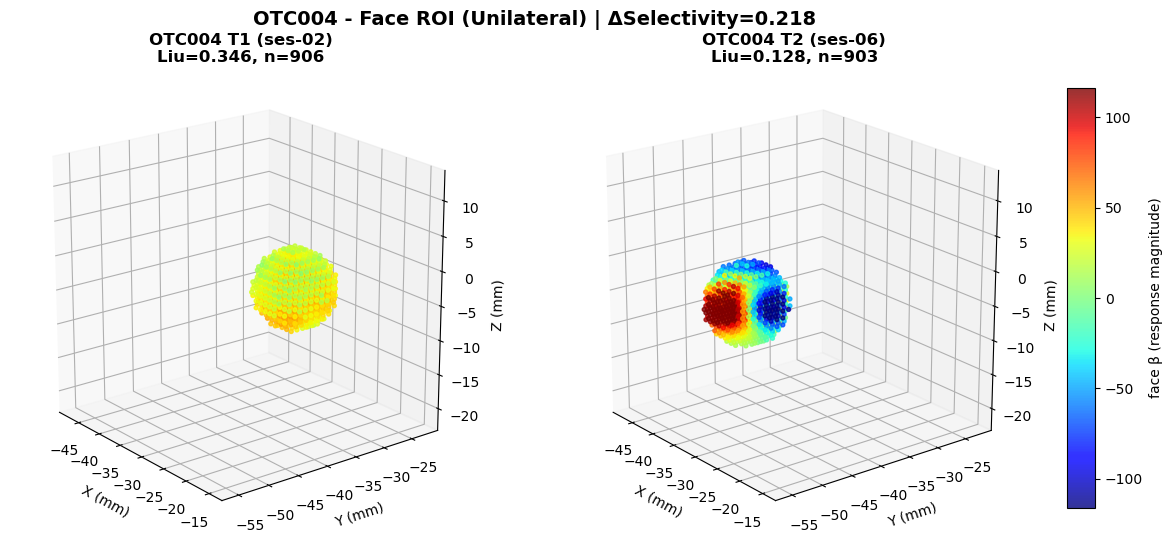

  ✓ Saved: sub-004_word_liu.png


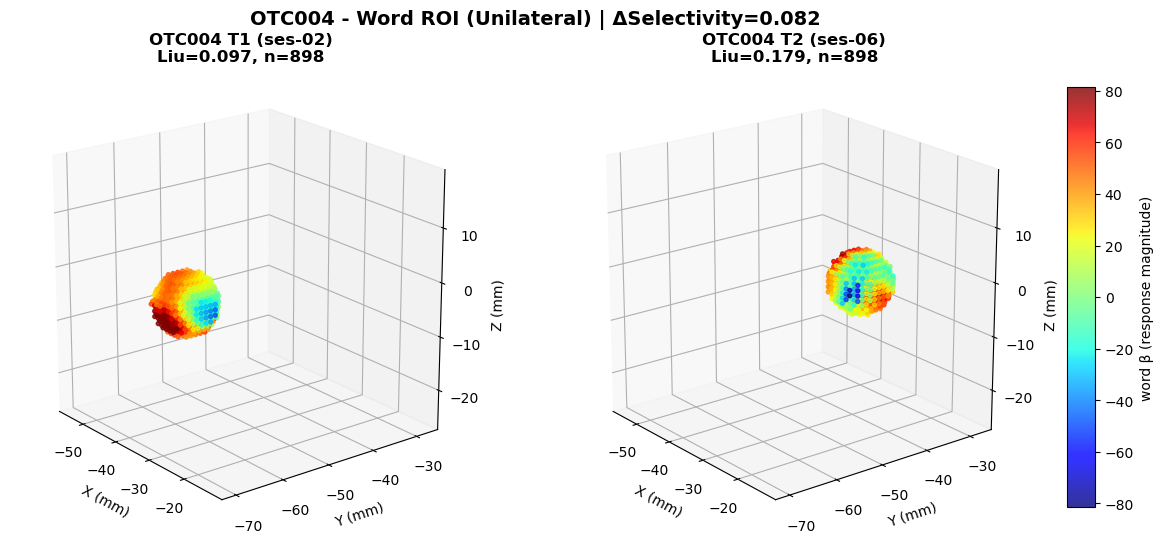

  ✓ Saved: sub-004_object_liu.png


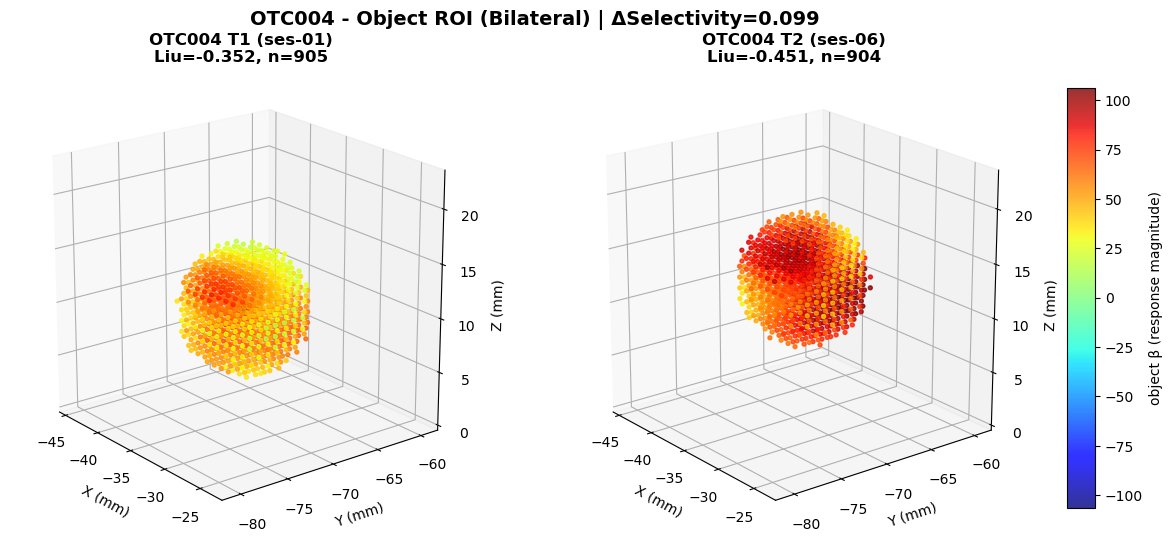

  ✓ Saved: sub-004_house_liu.png


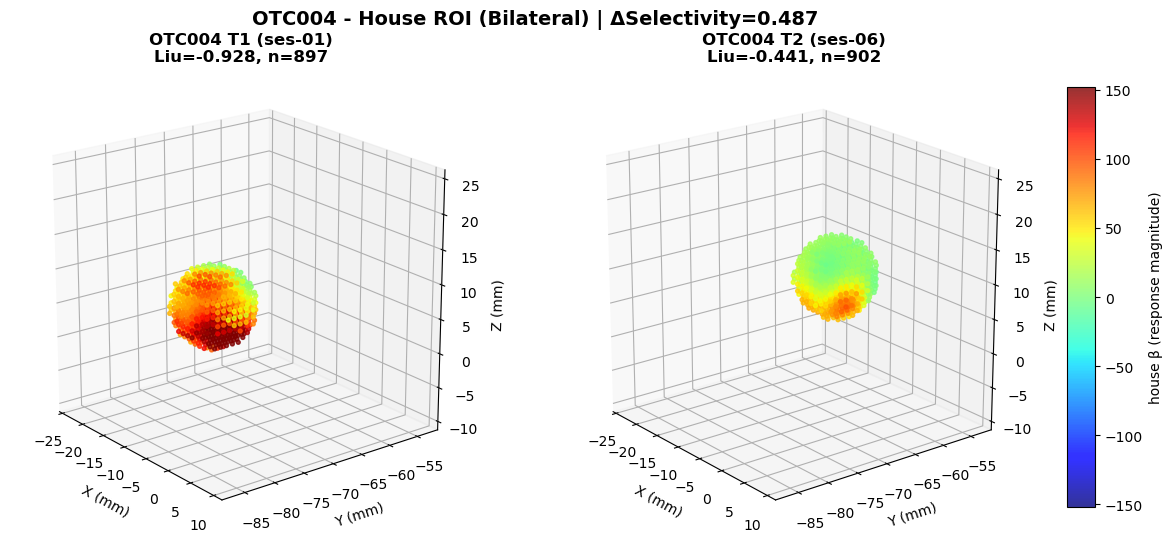


OTC008
----------------------------------------
  ✓ Saved: sub-008_face_liu.png


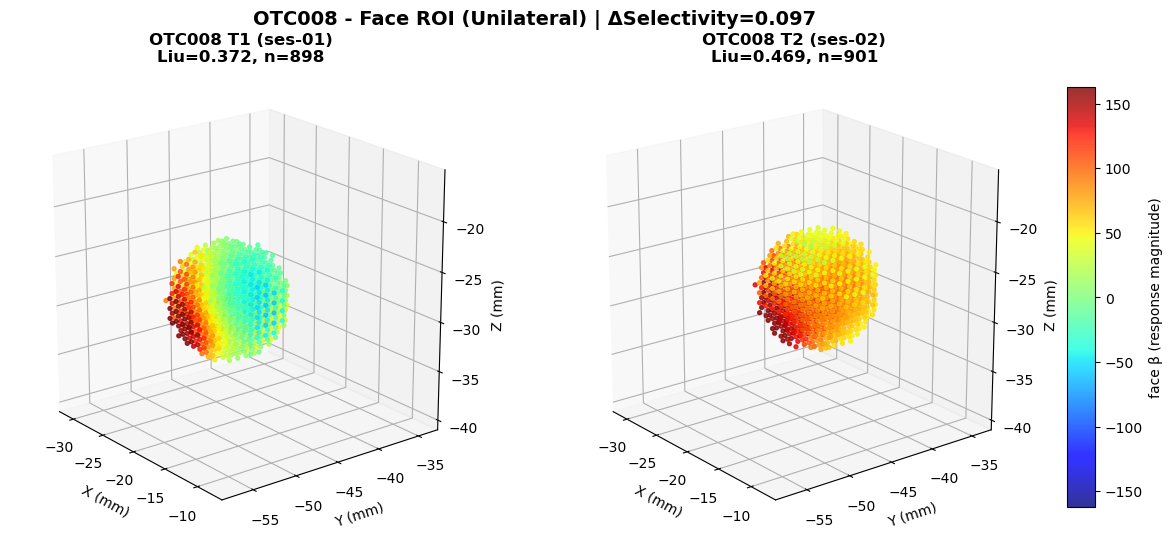

❌ OTC008 word: only 1 valid session(s)
  ✓ Saved: sub-008_object_liu.png


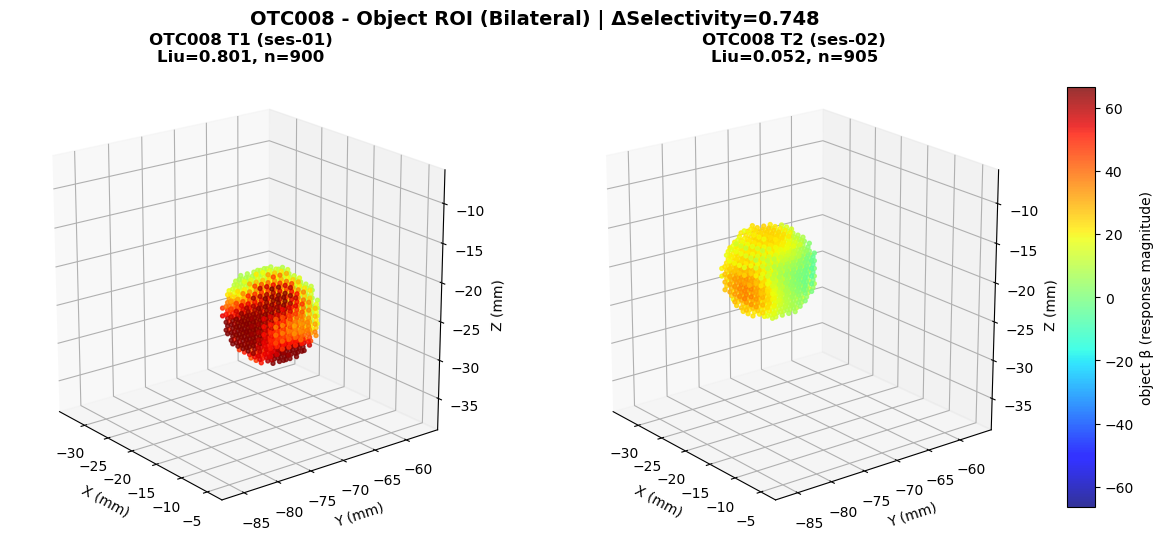

  ✓ Saved: sub-008_house_liu.png


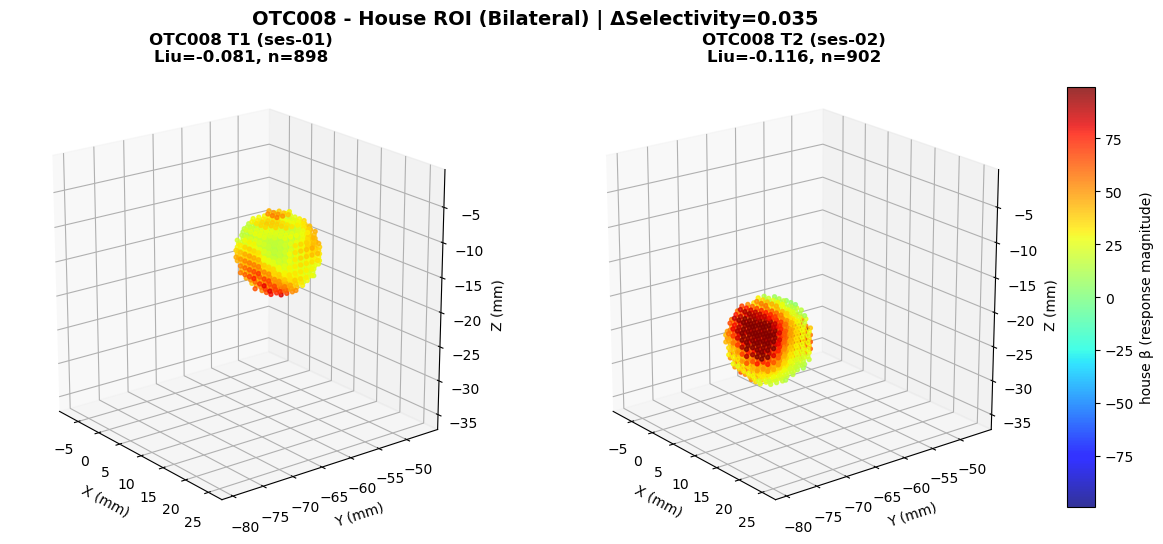


OTC010
----------------------------------------
  ✓ Saved: sub-010_face_liu.png


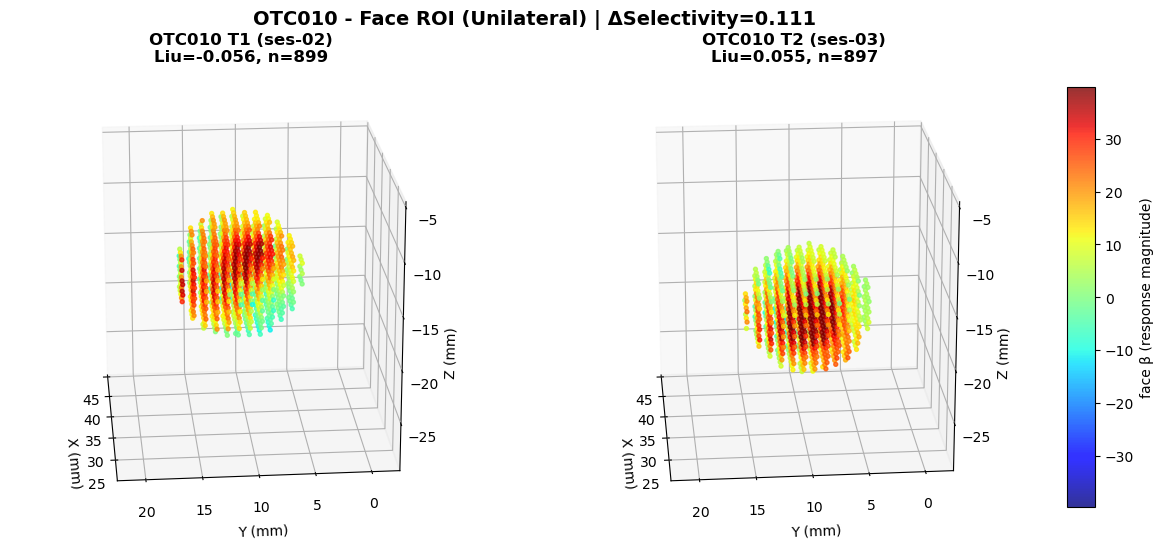

  ✓ Saved: sub-010_word_liu.png


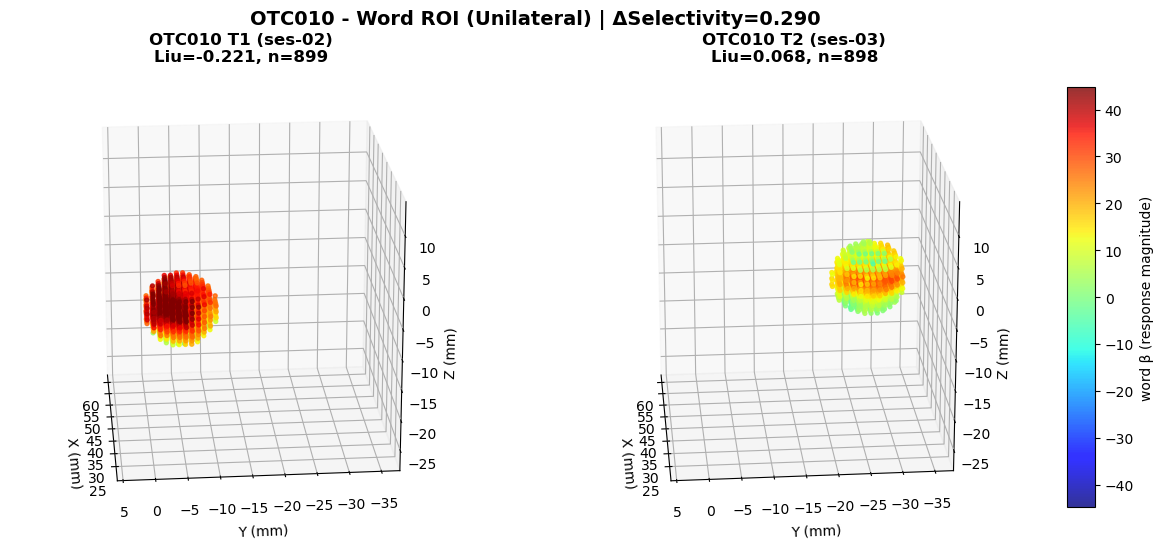

  ✓ Saved: sub-010_object_liu.png


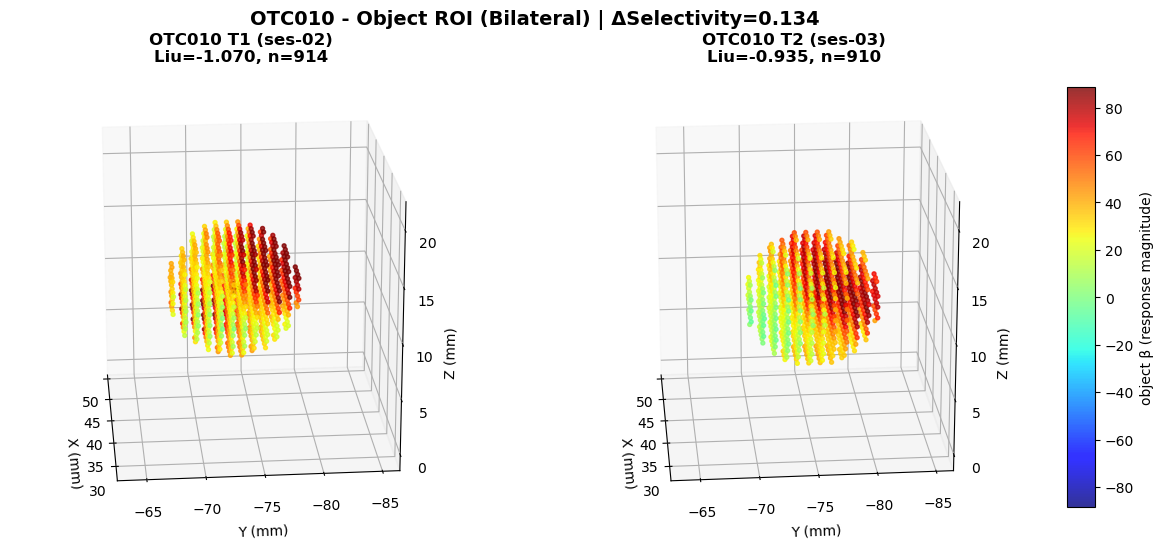

  ✓ Saved: sub-010_house_liu.png


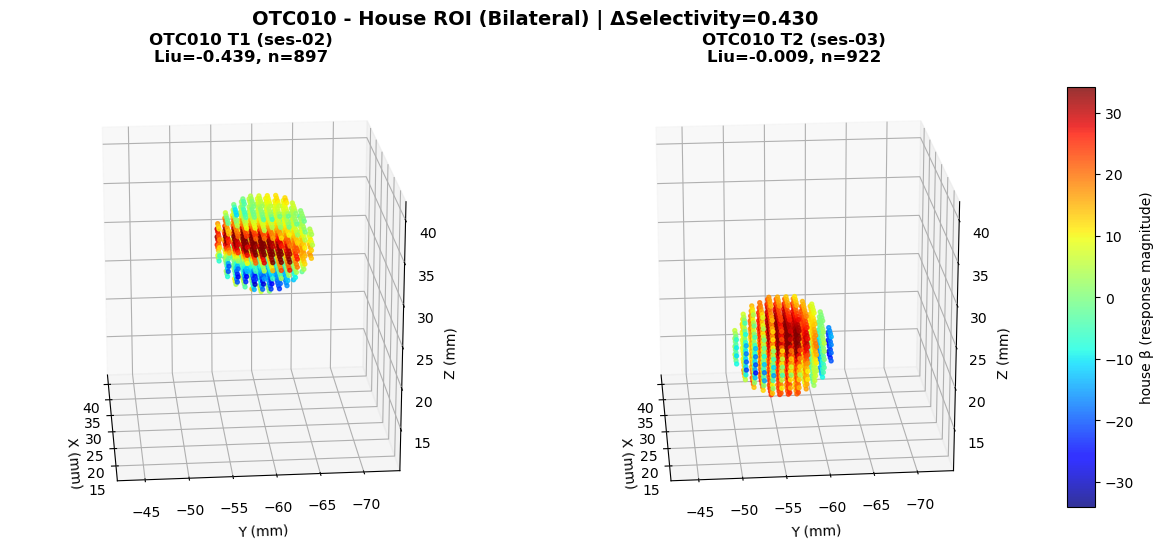


OTC017
----------------------------------------
  ✓ Saved: sub-017_face_liu.png


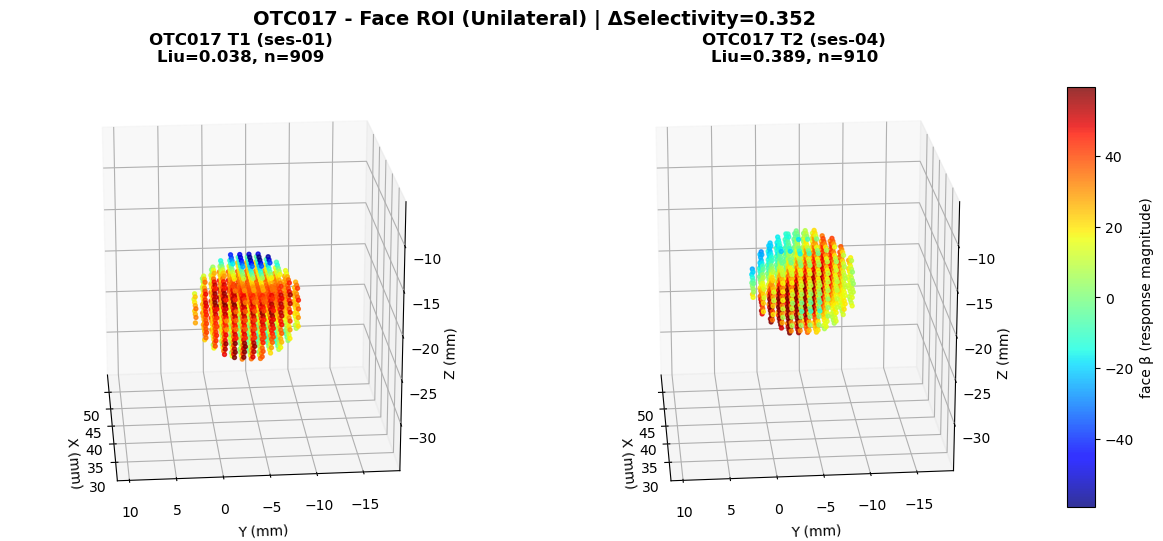

  ✓ Saved: sub-017_word_liu.png


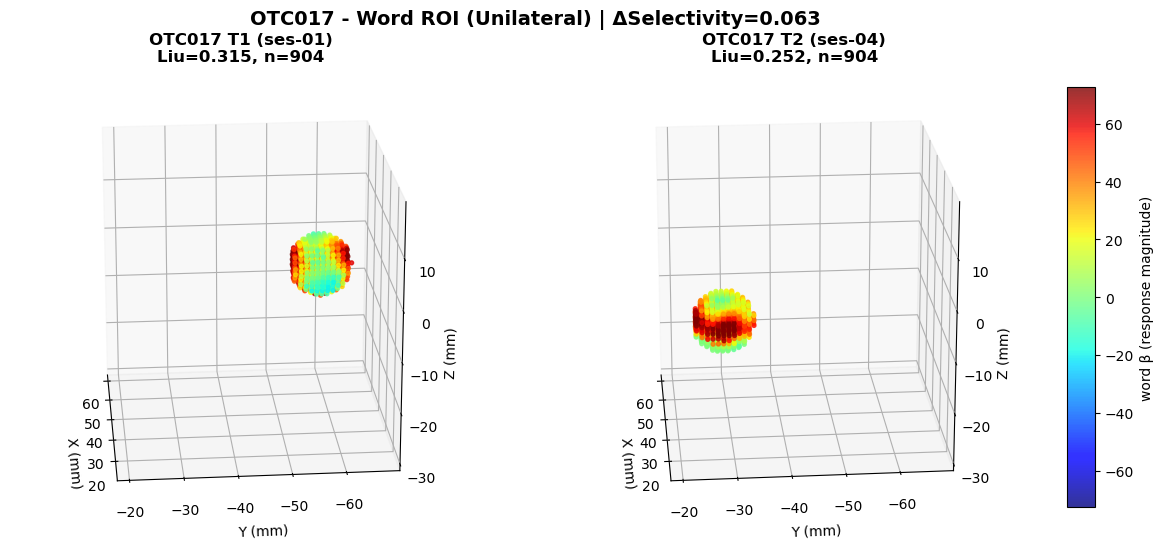

  ✓ Saved: sub-017_object_liu.png


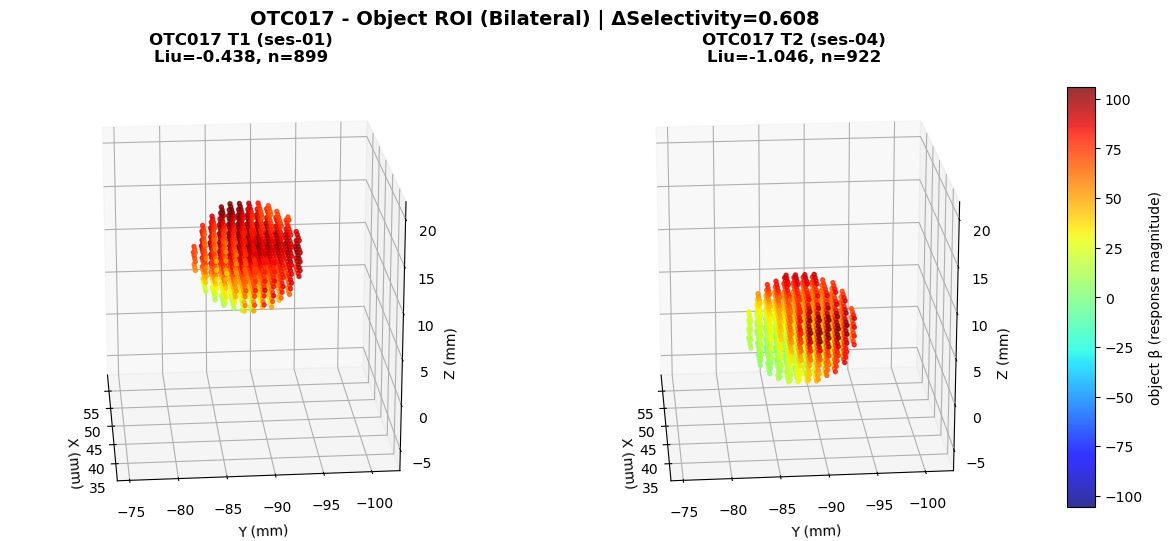

  ✓ Saved: sub-017_house_liu.png


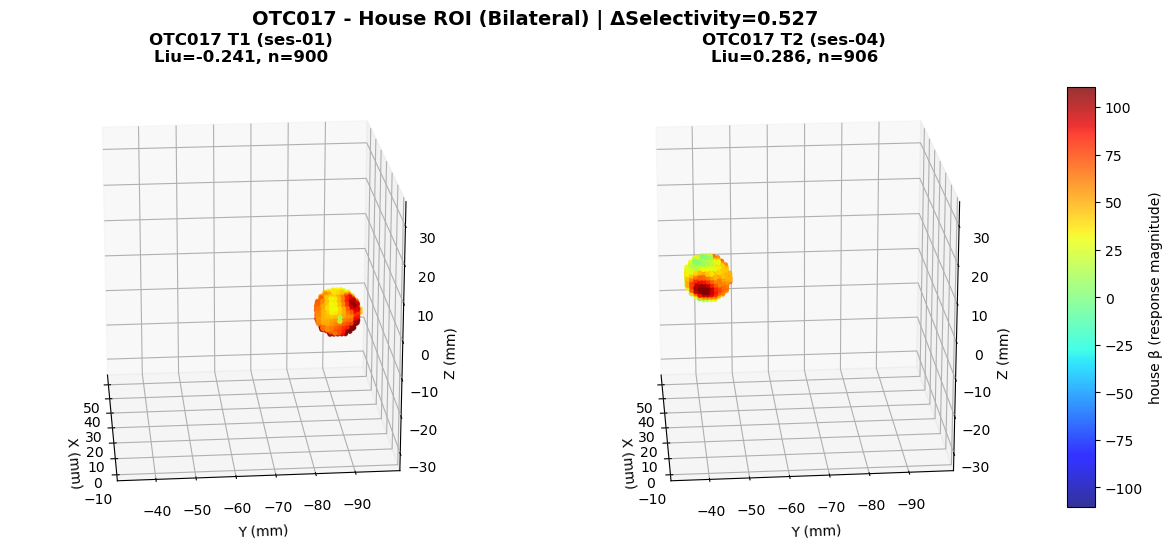


OTC021
----------------------------------------
  ✓ Saved: sub-021_face_liu.png


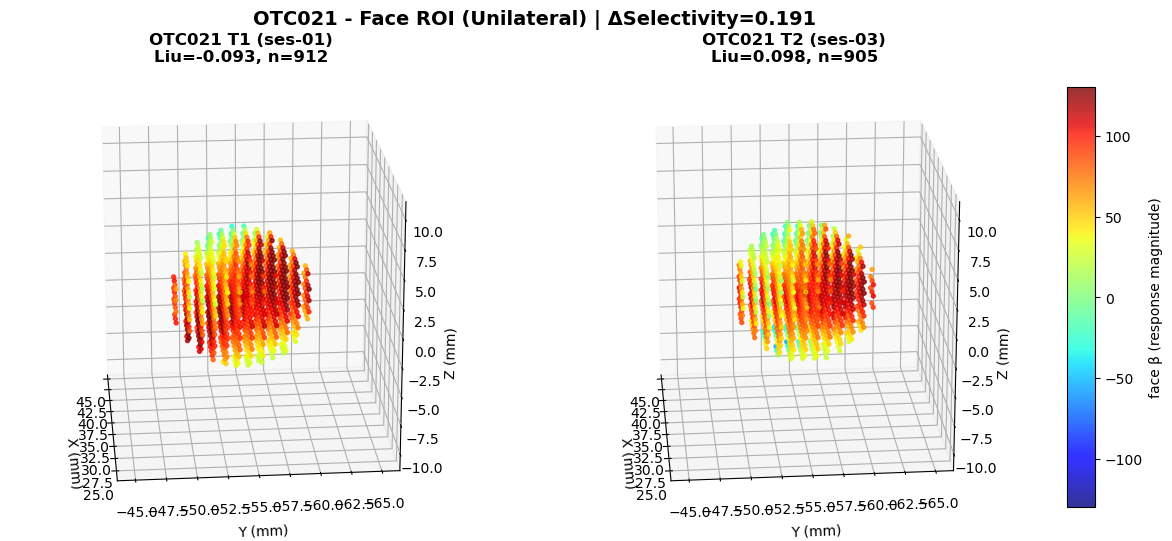

  ✓ Saved: sub-021_word_liu.png


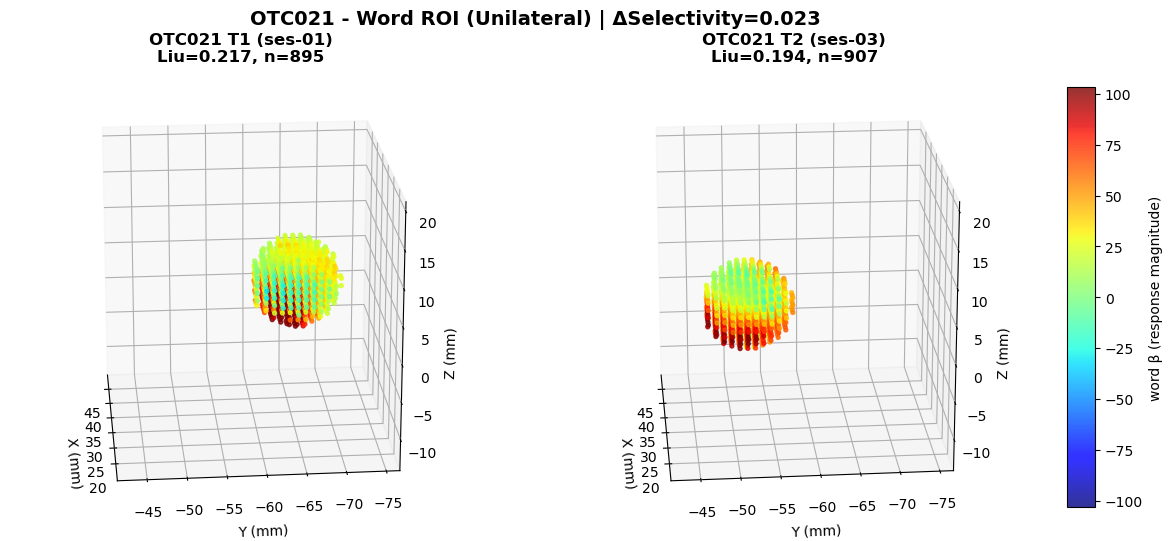

  ✓ Saved: sub-021_object_liu.png


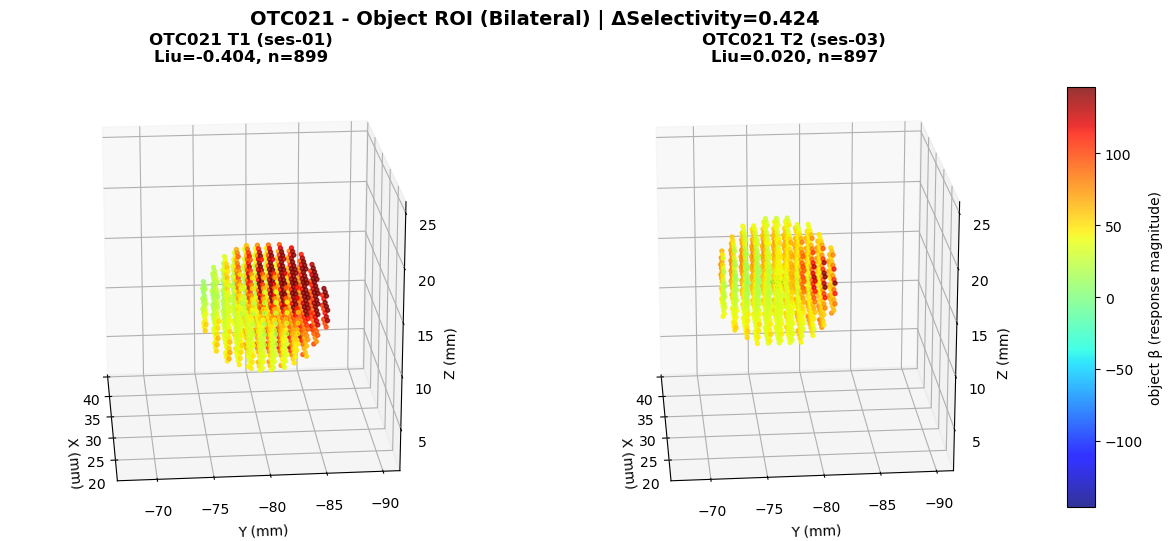

  ✓ Saved: sub-021_house_liu.png


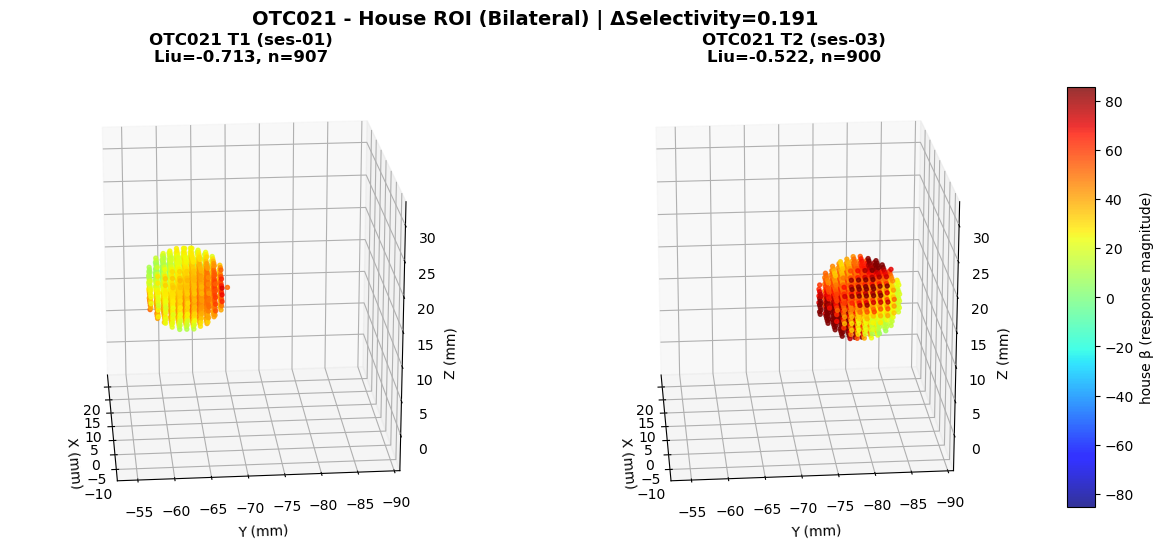


OTC079
----------------------------------------
  ✓ Saved: sub-079_face_liu.png


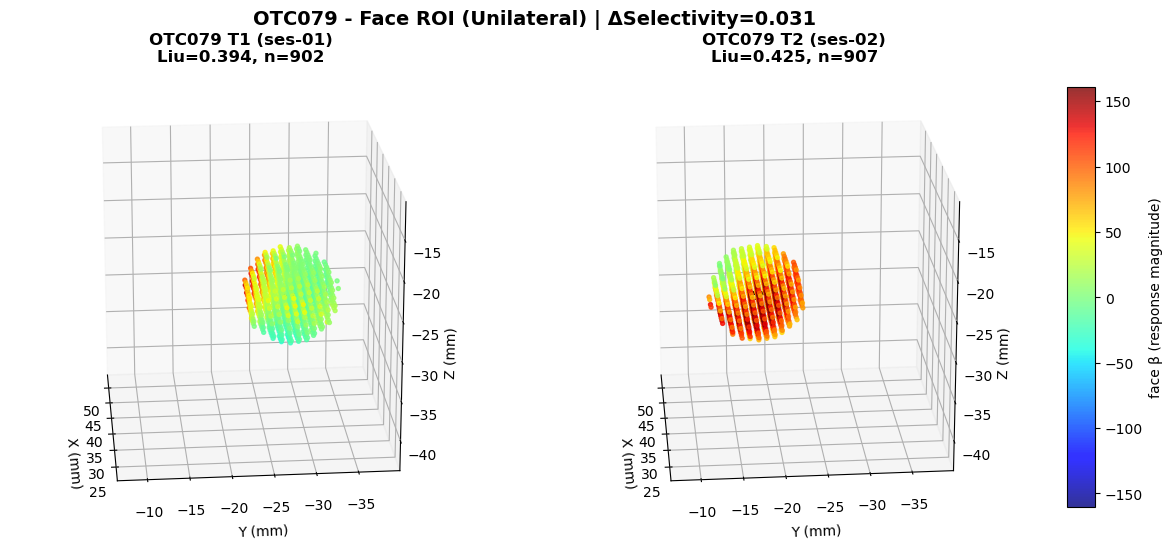

  ✓ Saved: sub-079_word_liu.png


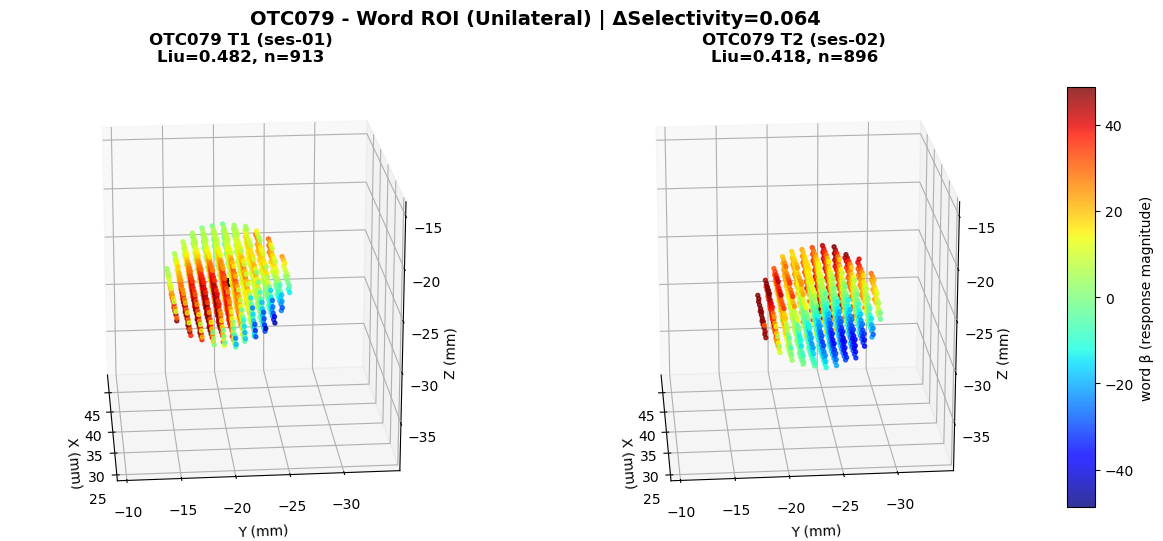

  ✓ Saved: sub-079_object_liu.png


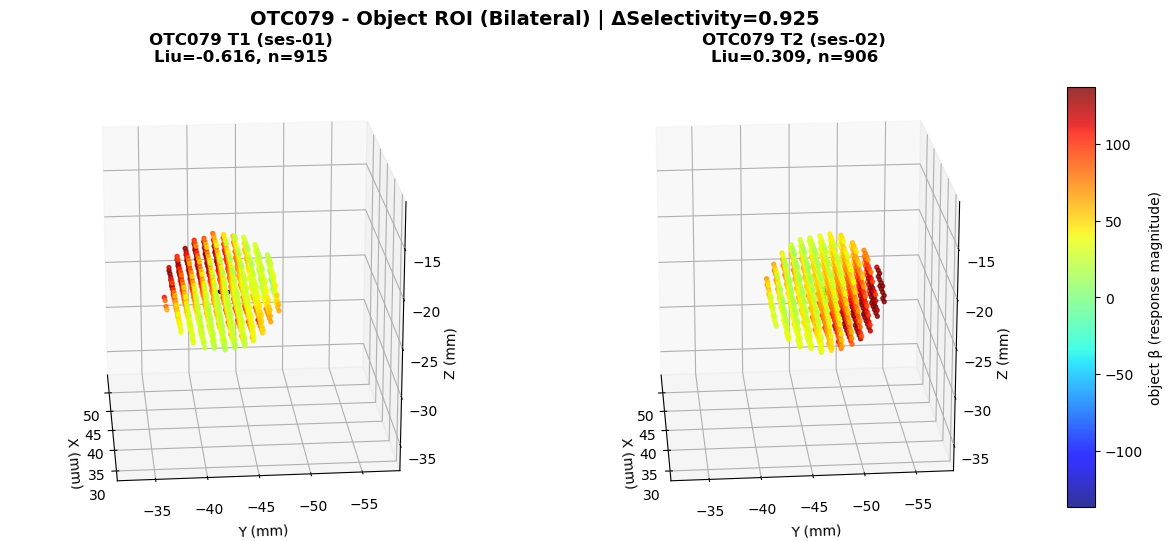

  ✓ Saved: sub-079_house_liu.png


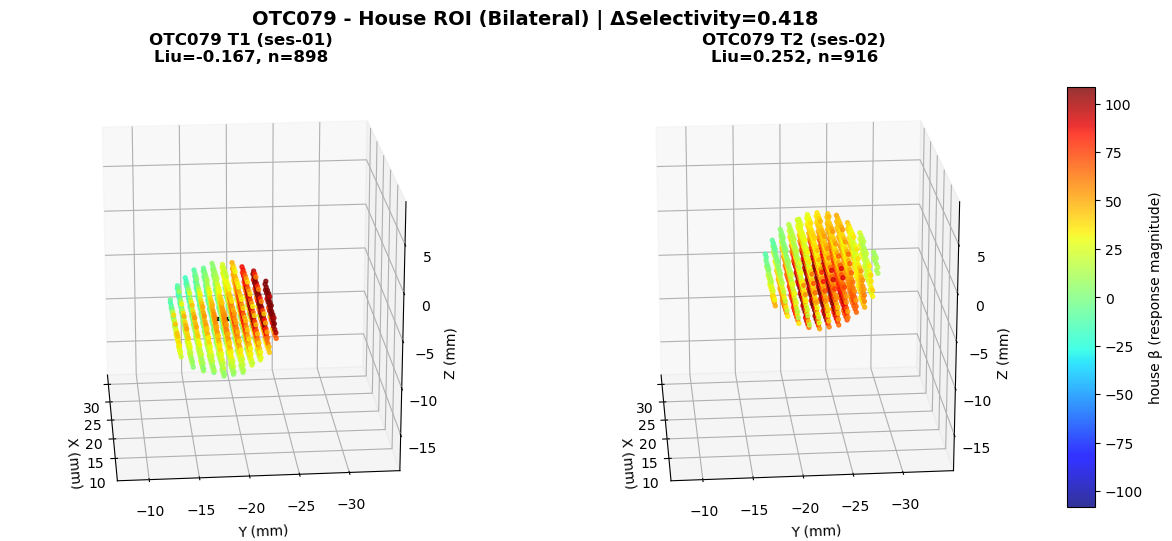


SUMMARY: SELECTIVITY CHANGE (should match CSV)

Subject    Category   Type         Selectivity_Change
-------------------------------------------------------
OTC004     face       Unilateral   0.218             
OTC004     word       Unilateral   0.082             
OTC004     object     Bilateral    0.099             
OTC004     house      Bilateral    0.487             
OTC008     face       Unilateral   0.097             
OTC008     object     Bilateral    0.748             
OTC008     house      Bilateral    0.035             
OTC010     face       Unilateral   0.111             
OTC010     word       Unilateral   0.290             
OTC010     object     Bilateral    0.134             
OTC010     house      Bilateral    0.430             
OTC017     face       Unilateral   0.352             
OTC017     word       Unilateral   0.063             
OTC017     object     Bilateral    0.608             
OTC017     house      Bilateral    0.527             
OTC021     face       Unilatera

In [28]:
# Cell 4
"""
FIGURE NOTEBOOK - Cell 4: Generate All Liu Distinctiveness Figures
"""

# Update visualization to fix aspect ratio
def visualize_liu_distinctiveness(subject_id, category, sessions_to_plot=None, radius=6, save=False):
    """
    Visualize ROI with Liu distinctiveness calculation
    Colorbar = beta values; Title = Liu distinctiveness
    """
    
    if subject_id not in OTC_SUBJECTS:
        print(f"❌ {subject_id} not found")
        return
    
    info = OTC_SUBJECTS[subject_id]
    code = info['code']
    hemi = info['hemi']
    sessions = info['sessions']
    
    # Find valid sessions
    if sessions_to_plot is None:
        valid_sessions = []
        for ses in sessions:
            data = get_roi_data_liu(subject_id, ses, category, hemi, radius=radius)
            if data is not None:
                valid_sessions.append(ses)
        
        if len(valid_sessions) < 2:
            print(f"❌ {code} {category}: only {len(valid_sessions)} valid session(s)")
            return
        
        sessions_to_plot = [valid_sessions[0], valid_sessions[-1]]
    
    # Collect data
    session_data = {}
    final_sessions = []
    
    for ses in sessions_to_plot:
        data = get_roi_data_liu(subject_id, ses, category, hemi, radius=radius)
        
        if data is None:
            print(f"  ⚠️  {code} ses-{ses} {category}: no valid ROI")
            continue
        
        session_data[ses] = data
        final_sessions.append(ses)
    
    if len(final_sessions) < 2:
        print(f"❌ {code} {category}: need at least 2 valid sessions")
        return
    
    # Compute shared axis limits (make cubic for sphere appearance)
    all_coords = np.vstack([session_data[s]['world_coords'] for s in final_sessions])
    x_range = all_coords[:,0].max() - all_coords[:,0].min()
    y_range = all_coords[:,1].max() - all_coords[:,1].min()
    z_range = all_coords[:,2].max() - all_coords[:,2].min()
    max_range = max(x_range, y_range, z_range) / 2 + 5
    
    x_mid = (all_coords[:,0].max() + all_coords[:,0].min()) / 2
    y_mid = (all_coords[:,1].max() + all_coords[:,1].min()) / 2
    z_mid = (all_coords[:,2].max() + all_coords[:,2].min()) / 2
    
    x_lim = [x_mid - max_range, x_mid + max_range]
    y_lim = [y_mid - max_range, y_mid + max_range]
    z_lim = [z_mid - max_range, z_mid + max_range]
    
    # Shared color limits for betas
    all_betas = np.concatenate([session_data[s]['preferred_betas'] for s in final_sessions])
    vmax = np.percentile(np.abs(all_betas), 95)
    vmin = -vmax
    
    # Create figure
    n_sessions = len(final_sessions)
    fig = plt.figure(figsize=(6 * n_sessions + 2, 6))
    
    view = (20, 175) if hemi == 'r' else (20, 322)
    
    for i, ses in enumerate(final_sessions):
        data = session_data[ses]
        coords = data['world_coords']
        betas = data['preferred_betas']
        centroid = data['centroid']
        liu = data['liu_distinctiveness']
        
        ax = fig.add_subplot(1, n_sessions, i + 1, projection='3d')
        
        scatter = ax.scatter(
            coords[:, 0], coords[:, 1], coords[:, 2],
            c=betas, s=8, marker='o',
            cmap='jet', vmin=vmin, vmax=vmax, alpha=0.8
        )
        
        # Mark centroid
        ax.scatter([centroid[0]], [centroid[1]], [centroid[2]], 
                   c='black', s=100, marker='+', linewidths=3)
        
        # Equal axis limits for sphere appearance
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_zlim(z_lim)
        ax.set_box_aspect([1,1,1])  # Equal aspect ratio
        
        ax.set_xlabel('X (mm)', fontsize=10)
        ax.set_ylabel('Y (mm)', fontsize=10)
        ax.set_zlabel('Z (mm)', fontsize=10)
        
        session_label = f"T{i+1} (ses-{ses})"
        ax.set_title(f'{code} {session_label}\nLiu={liu:.3f}, n={data["n_voxels"]}', 
                     fontsize=12, fontweight='bold')
        
        ax.view_init(elev=view[0], azim=view[1])
        ax.grid(True, alpha=0.3)
    
    # Colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label(f'{category} β (response magnitude)', fontsize=10)
    
    # Suptitle
    cat_type = CATEGORY_TYPE[category]
    t1_liu = session_data[final_sessions[0]]['liu_distinctiveness']
    t2_liu = session_data[final_sessions[-1]]['liu_distinctiveness']
    selectivity_change = abs(t2_liu - t1_liu)
    
    fig.suptitle(f'{code} - {category.capitalize()} ROI ({cat_type}) | ΔSelectivity={selectivity_change:.3f}', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    if save:
        save_path = OUTPUT_DIR / f'{subject_id}_{category}_liu.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {save_path.name}")
    
    plt.show()
    
    return session_data, selectivity_change


# Generate all figures
print("GENERATING ALL LIU DISTINCTIVENESS FIGURES")
print("=" * 70)

all_results = {}
summary_data = []

for subject_id in OTC_SUBJECTS.keys():
    code = OTC_SUBJECTS[subject_id]['code']
    all_results[subject_id] = {}
    
    print(f"\n{code}")
    print("-" * 40)
    
    for category in ['face', 'word', 'object', 'house']:
        result = visualize_liu_distinctiveness(
            subject_id, 
            category, 
            sessions_to_plot=None,
            radius=6,
            save=True
        )
        
        if result is not None:
            session_data, selectivity_change = result
            all_results[subject_id][category] = session_data
            
            summary_data.append({
                'Subject': code,
                'Category': category,
                'Type': CATEGORY_TYPE[category],
                'Selectivity_Change': selectivity_change
            })

# Summary table
print("\n" + "=" * 70)
print("SUMMARY: SELECTIVITY CHANGE (should match CSV)")
print("=" * 70)

summary_df = pd.DataFrame(summary_data)
print(f"\n{'Subject':<10} {'Category':<10} {'Type':<12} {'Selectivity_Change':<18}")
print("-" * 55)

for _, row in summary_df.iterrows():
    print(f"{row['Subject']:<10} {row['Category']:<10} {row['Type']:<12} {row['Selectivity_Change']:<18.3f}")

# Compare to CSV
print("\n" + "=" * 70)
print("VERIFICATION vs CSV")
print("=" * 70)

results_csv = Path('/user_data/csimmon2/git_repos/long_pt/results_final_corrected.csv')
csv_df = pd.read_csv(results_csv)
otc_csv = csv_df[csv_df['Group'] == 'OTC']

print(f"\n{'Subject':<10} {'Category':<10} {'Viz':<10} {'CSV':<10} {'Match?':<8}")
print("-" * 55)

for _, row in summary_df.iterrows():
    csv_row = otc_csv[(otc_csv['Subject'] == row['Subject']) & 
                       (otc_csv['Category'] == row['Category'].capitalize())]
    if len(csv_row) > 0:
        csv_val = csv_row['Selectivity_Change'].values[0]
        match = "✓" if abs(row['Selectivity_Change'] - csv_val) < 0.01 else "❌"
        print(f"{row['Subject']:<10} {row['Category']:<10} {row['Selectivity_Change']:<10.3f} {csv_val:<10.3f} {match:<8}")

# Summary by type
print("\n" + "=" * 70)
print("BILATERAL vs UNILATERAL SUMMARY")
print("=" * 70)

bil = summary_df[summary_df['Type'] == 'Bilateral']['Selectivity_Change']
uni = summary_df[summary_df['Type'] == 'Unilateral']['Selectivity_Change']

print(f"\nBilateral (n={len(bil)}):  {bil.mean():.3f} ± {bil.std():.3f}")
print(f"Unilateral (n={len(uni)}): {uni.mean():.3f} ± {uni.std():.3f}")
print(f"Difference: {bil.mean() - uni.mean():.3f}")

In [29]:
"""
Cell 5: Directional Analysis - Does selectivity increase or decrease?
"""

print("DIRECTIONAL ANALYSIS: Liu Distinctiveness T1 → T2")
print("=" * 70)
print("Note: More NEGATIVE = MORE distinct/selective")
print("      More POSITIVE = LESS distinct/selective (like Liu's word crowding)")
print("=" * 70)

print(f"\n{'Subject':<10} {'Category':<10} {'Type':<12} {'T1 Liu':<10} {'T2 Liu':<10} {'Direction':<12}")
print("-" * 70)

for subject_id in OTC_SUBJECTS.keys():
    code = OTC_SUBJECTS[subject_id]['code']
    
    for category in ['face', 'word', 'object', 'house']:
        if subject_id in all_results and category in all_results[subject_id]:
            data = all_results[subject_id][category]
            sessions = list(data.keys())
            
            if len(sessions) >= 2:
                t1_liu = data[sessions[0]]['liu_distinctiveness']
                t2_liu = data[sessions[-1]]['liu_distinctiveness']
                
                if t2_liu > t1_liu:
                    direction = "↑ LESS selective"
                else:
                    direction = "↓ MORE selective"
                
                cat_type = CATEGORY_TYPE[category]
                print(f"{code:<10} {category:<10} {cat_type:<12} {t1_liu:<10.3f} {t2_liu:<10.3f} {direction:<12}")

# Summary by type
print("\n" + "=" * 70)
print("SUMMARY: Mean CHANGE (not absolute) by category type")
print("Positive = became less selective; Negative = became more selective")
print("=" * 70)

DIRECTIONAL ANALYSIS: Liu Distinctiveness T1 → T2
Note: More NEGATIVE = MORE distinct/selective
      More POSITIVE = LESS distinct/selective (like Liu's word crowding)

Subject    Category   Type         T1 Liu     T2 Liu     Direction   
----------------------------------------------------------------------
OTC004     face       Unilateral   0.346      0.128      ↓ MORE selective
OTC004     word       Unilateral   0.097      0.179      ↑ LESS selective
OTC004     object     Bilateral    -0.352     -0.451     ↓ MORE selective
OTC004     house      Bilateral    -0.928     -0.441     ↑ LESS selective
OTC008     face       Unilateral   0.372      0.469      ↑ LESS selective
OTC008     object     Bilateral    0.801      0.052      ↓ MORE selective
OTC008     house      Bilateral    -0.081     -0.116     ↓ MORE selective
OTC010     face       Unilateral   -0.056     0.055      ↑ LESS selective
OTC010     word       Unilateral   -0.221     0.068      ↑ LESS selective
OTC010     object     B

In [30]:
# Compute mean directional change
bilateral_changes = []
unilateral_changes = []

for subject_id in OTC_SUBJECTS.keys():
    for category in ['face', 'word', 'object', 'house']:
        if subject_id in all_results and category in all_results[subject_id]:
            data = all_results[subject_id][category]
            sessions = list(data.keys())
            
            if len(sessions) >= 2:
                t1_liu = data[sessions[0]]['liu_distinctiveness']
                t2_liu = data[sessions[-1]]['liu_distinctiveness']
                change = t2_liu - t1_liu  # Positive = less selective
                
                if CATEGORY_TYPE[category] == 'Bilateral':
                    bilateral_changes.append(change)
                else:
                    unilateral_changes.append(change)

print(f"Bilateral (n={len(bilateral_changes)}):  mean Δ = {np.mean(bilateral_changes):.3f}")
print(f"Unilateral (n={len(unilateral_changes)}): mean Δ = {np.mean(unilateral_changes):.3f}")
print(f"\nPositive = became LESS selective (like Liu's word crowding)")
print(f"Negative = became MORE selective")

Bilateral (n=12):  mean Δ = 0.170
Unilateral (n=11): mean Δ = 0.072

Positive = became LESS selective (like Liu's word crowding)
Negative = became MORE selective


✓ Saved: /user_data/csimmon2/long_pt/analyses/figures/selectivity_change_barplot.png


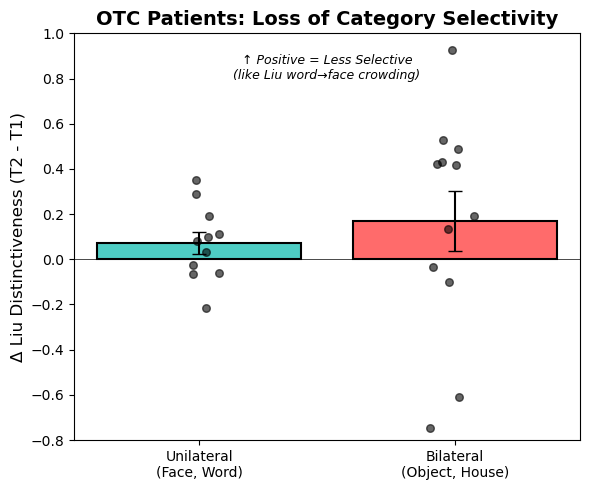


Unilateral: 0.072 ± 0.048 (n=11)
Bilateral:  0.170 ± 0.133 (n=12)


In [32]:
"""
FIGURE NOTEBOOK - Cell 5: Summary Bar Plot (Directional Change)
"""

import matplotlib.pyplot as plt
import numpy as np

# Compute directional changes
bilateral_changes = []
unilateral_changes = []

for subject_id in OTC_SUBJECTS.keys():
    for category in ['face', 'word', 'object', 'house']:
        if subject_id in all_results and category in all_results[subject_id]:
            data = all_results[subject_id][category]
            sessions = list(data.keys())
            
            if len(sessions) >= 2:
                t1_liu = data[sessions[0]]['liu_distinctiveness']
                t2_liu = data[sessions[-1]]['liu_distinctiveness']
                change = t2_liu - t1_liu  # Positive = less selective
                
                if CATEGORY_TYPE[category] == 'Bilateral':
                    bilateral_changes.append(change)
                else:
                    unilateral_changes.append(change)

# Bar plot
fig, ax = plt.subplots(figsize=(6, 5))

means = [np.mean(unilateral_changes), np.mean(bilateral_changes)]
sems = [np.std(unilateral_changes)/np.sqrt(len(unilateral_changes)), 
        np.std(bilateral_changes)/np.sqrt(len(bilateral_changes))]

colors = ['#4ECDC4', '#FF6B6B']  # Teal, Coral
bars = ax.bar(['Unilateral\n(Face, Word)', 'Bilateral\n(Object, House)'], 
              means, yerr=sems, capsize=5, color=colors, edgecolor='black', linewidth=1.5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Δ Liu Distinctiveness (T2 - T1)', fontsize=12)
ax.set_title('OTC Patients: Loss of Category Selectivity', fontsize=14, fontweight='bold')

# Add individual points
np.random.seed(42)
x_uni = np.random.normal(0, 0.05, len(unilateral_changes))
x_bil = np.random.normal(1, 0.05, len(bilateral_changes))
ax.scatter(x_uni, unilateral_changes, color='black', alpha=0.6, s=30, zorder=3)
ax.scatter(x_bil, bilateral_changes, color='black', alpha=0.6, s=30, zorder=3)

# Annotation
ax.text(0.5, 0.95, '↑ Positive = Less Selective\n(like Liu word→face crowding)', 
        transform=ax.transAxes, ha='center', va='top', fontsize=9, style='italic')

ax.set_ylim(-0.8, 1.0)
plt.tight_layout()

save_path = OUTPUT_DIR / 'selectivity_change_barplot.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path}")

plt.show()

print(f"\nUnilateral: {np.mean(unilateral_changes):.3f} ± {np.std(unilateral_changes)/np.sqrt(len(unilateral_changes)):.3f} (n={len(unilateral_changes)})")
print(f"Bilateral:  {np.mean(bilateral_changes):.3f} ± {np.std(bilateral_changes)/np.sqrt(len(bilateral_changes)):.3f} (n={len(bilateral_changes)})")

In [34]:
# Face vs Word directional comparison
face_changes = []
word_changes = []

for subject_id in OTC_SUBJECTS.keys():
    for category in ['face', 'word']:
        if subject_id in all_results and category in all_results[subject_id]:
            data = all_results[subject_id][category]
            sessions = list(data.keys())
            if len(sessions) >= 2:
                change = data[sessions[-1]]['liu_distinctiveness'] - data[sessions[0]]['liu_distinctiveness']
                if category == 'face':
                    face_changes.append(change)
                else:
                    word_changes.append(change)

print(f"Face (n={len(face_changes)}):  {np.mean(face_changes):.3f} ± {np.std(face_changes):.3f}")
print(f"Word (n={len(word_changes)}): {np.mean(word_changes):.3f} ± {np.std(word_changes):.3f}")

Face (n=6):  0.094 ± 0.172
Word (n=5): 0.045 ± 0.134


In [35]:
# Object vs House directional comparison
object_changes = []
house_changes = []

for subject_id in OTC_SUBJECTS.keys():
    for category in ['object', 'house']:
        if subject_id in all_results and category in all_results[subject_id]:
            data = all_results[subject_id][category]
            sessions = list(data.keys())
            if len(sessions) >= 2:
                change = data[sessions[-1]]['liu_distinctiveness'] - data[sessions[0]]['liu_distinctiveness']
                if category == 'object':
                    object_changes.append(change)
                else:
                    house_changes.append(change)

print(f"Object (n={len(object_changes)}): {np.mean(object_changes):.3f} ± {np.std(object_changes):.3f}")
print(f"House (n={len(house_changes)}):  {np.mean(house_changes):.3f} ± {np.std(house_changes):.3f}")

Object (n=6): 0.005 ± 0.576
House (n=6):  0.336 ± 0.197


# PLAYGROUND

/tmp/ipykernel_3306979/2464771725.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{c}\n(n={n})' for c, n in zip(categories, ns)])


✓ Saved: /user_data/csimmon2/long_pt/analyses/figures/selectivity_change_by_category.png


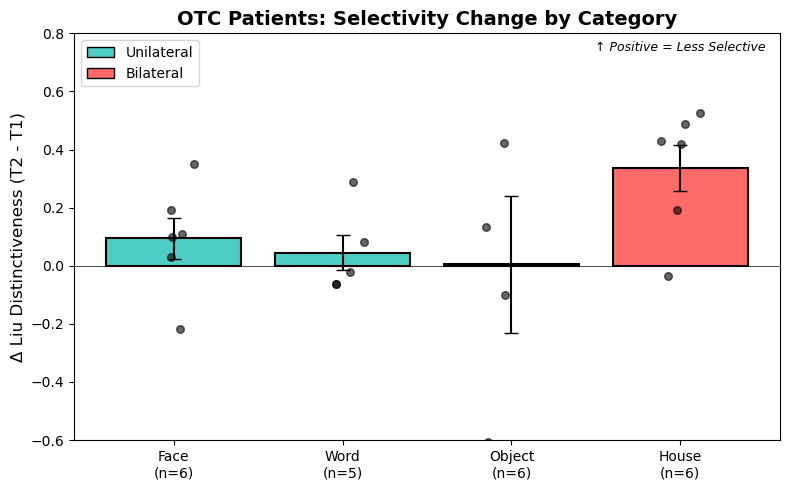


Category   n    Mean Δ     SEM       
-----------------------------------
Face       6    0.094      0.070     
Word       5    0.045      0.060     
Object     6    0.005      0.235     
House      6    0.336      0.081     


In [36]:
"""
Cell 7: Bar Plot by Individual Category (Directional Change)
"""

# Compute directional changes by category
category_changes = {'face': [], 'word': [], 'object': [], 'house': []}

for subject_id in OTC_SUBJECTS.keys():
    for category in ['face', 'word', 'object', 'house']:
        if subject_id in all_results and category in all_results[subject_id]:
            data = all_results[subject_id][category]
            sessions = list(data.keys())
            if len(sessions) >= 2:
                change = data[sessions[-1]]['liu_distinctiveness'] - data[sessions[0]]['liu_distinctiveness']
                category_changes[category].append(change)

# Bar plot
fig, ax = plt.subplots(figsize=(8, 5))

categories = ['Face', 'Word', 'Object', 'House']
means = [np.mean(category_changes[c.lower()]) for c in categories]
sems = [np.std(category_changes[c.lower()])/np.sqrt(len(category_changes[c.lower()])) for c in categories]
ns = [len(category_changes[c.lower()]) for c in categories]

# Colors: Unilateral = teal, Bilateral = coral
colors = ['#4ECDC4', '#4ECDC4', '#FF6B6B', '#FF6B6B']

bars = ax.bar(categories, means, yerr=sems, capsize=5, color=colors, edgecolor='black', linewidth=1.5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Δ Liu Distinctiveness (T2 - T1)', fontsize=12)
ax.set_title('OTC Patients: Selectivity Change by Category', fontsize=14, fontweight='bold')

# Add individual points
np.random.seed(42)
for i, cat in enumerate(['face', 'word', 'object', 'house']):
    x_jitter = np.random.normal(i, 0.08, len(category_changes[cat]))
    ax.scatter(x_jitter, category_changes[cat], color='black', alpha=0.6, s=30, zorder=3)

# Add n to x-axis labels
ax.set_xticklabels([f'{c}\n(n={n})' for c, n in zip(categories, ns)])

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#4ECDC4', edgecolor='black', label='Unilateral'),
                   Patch(facecolor='#FF6B6B', edgecolor='black', label='Bilateral')]
ax.legend(handles=legend_elements, loc='upper left')

# Annotation
ax.text(0.98, 0.98, '↑ Positive = Less Selective', 
        transform=ax.transAxes, ha='right', va='top', fontsize=9, style='italic')

ax.set_ylim(-0.6, 0.8)
plt.tight_layout()

save_path = OUTPUT_DIR / 'selectivity_change_by_category.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path}")

plt.show()

# Print stats
print(f"\n{'Category':<10} {'n':<4} {'Mean Δ':<10} {'SEM':<10}")
print("-" * 35)
for cat in ['face', 'word', 'object', 'house']:
    n = len(category_changes[cat])
    m = np.mean(category_changes[cat])
    sem = np.std(category_changes[cat])/np.sqrt(n)
    print(f"{cat.capitalize():<10} {n:<4} {m:<10.3f} {sem:<10.3f}")

In [4]:
"""
Figure 5 Setup: Load data and extract centroids
Run this cell first to prepare data for Ayzenberg-style visualization
"""

import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from scipy.ndimage import center_of_mass, label
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ============================================================
# CONFIGURATION
# ============================================================

BASE_DIR = Path("/user_data/csimmon2/long_pt")
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
RESULTS_CSV = Path('/user_data/csimmon2/git_repos/long_pt/results_final_corrected.csv')
OUTPUT_DIR = BASE_DIR / "analyses" / "figures"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Contrast map (differential)
COPE_MAP_DIFFERENTIAL = {
    'face': (1, 1),
    'house': (2, 1),
    'object': (3, 1),
    'word': (12, 1)
}

SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

CATEGORY_COLORS = {
    'face': '#E91E63',
    'word': '#FF9800',
    'object': '#00BCD4',
    'house': '#4CAF50'
}

CATEGORY_TYPE = {
    'face': 'Unilateral',
    'word': 'Unilateral',
    'object': 'Bilateral',
    'house': 'Bilateral'
}


# ============================================================
# EXCLUDED SUBJECTS
# ============================================================

EXCLUDED_SUBJECTS = ['sub-025', 'sub-027', 'sub-045', 'sub-072']

# ============================================================
# LOAD SUBJECT INFO
# ============================================================

def load_analysis_subjects():
    """Load all subjects (OTC, nonOTC, control) with metadata"""
    
    df = pd.read_csv(CSV_FILE)
    subjects = {}
    
    for _, row in df.iterrows():
        subject_id = row['sub']
        
        # Skip excluded subjects
        if subject_id in EXCLUDED_SUBJECTS:
            continue
        
        subj_dir = BASE_DIR / subject_id
        
        if not subj_dir.exists():
            continue

        sessions = sorted([s.name.replace('ses-', '') for s in subj_dir.glob('ses-*') if s.is_dir()])
        start = SESSION_START.get(subject_id, 1)
        sessions = [s for s in sessions if int(s) >= start]
        
        if len(sessions) < 2:
            continue
        
        # Determine group
        if row['patient'] == 1:
            group = row['group']  # 'OTC' or 'nonOTC'
            intact_hemi = 'l' if row['intact_hemi'] == 'left' else 'r'
        else:
            group = 'control'
            intact_hemi = None  # Controls have both hemispheres
        
        subjects[subject_id] = {
            'code': f"{group}{subject_id.split('-')[1]}" if group != 'control' else f"C{subject_id.split('-')[1]}",
            'sessions': sessions,
            'group': group,
            'intact_hemi': intact_hemi,
            'surgery_side': row.get('surgery_side', None),
            'age_1': row.get('age_1', None)
        }
    
    return subjects

ANALYSIS_SUBJECTS = load_analysis_subjects()
print(f"Loaded {len(ANALYSIS_SUBJECTS)} subjects:")
print(f"  OTC: {sum(1 for s in ANALYSIS_SUBJECTS.values() if s['group'] == 'OTC')}")
print(f"  nonOTC: {sum(1 for s in ANALYSIS_SUBJECTS.values() if s['group'] == 'nonOTC')}")
print(f"  control: {sum(1 for s in ANALYSIS_SUBJECTS.values() if s['group'] == 'control')}")

# ============================================================
# ROI EXTRACTION FUNCTION
# ============================================================

def extract_top20_rois(subject_id, cope_map, percentile=80, min_cluster_size=20):
    """Extract ROIs using top 20% of voxels within search mask"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): 
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, (cope_num, multiplier) in cope_map.items():
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): 
                continue
            
            try:
                search_mask_img = nib.load(mask_file)
                search_mask = search_mask_img.get_fdata() > 0
                affine = search_mask_img.affine
            except: 
                continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): 
                    continue
                
                try:
                    z_full = nib.load(cope_file).get_fdata() * multiplier
                    pos_voxels = z_full[search_mask & (z_full > 0)]
                    
                    if len(pos_voxels) < min_cluster_size: 
                        continue
                    
                    dynamic_thresh = max(np.percentile(pos_voxels, percentile), 1.64)
                    
                    suprathresh = (z_full > dynamic_thresh) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    
                    if n_clusters == 0: 
                        continue
                    
                    # Select largest cluster
                    best_idx, max_size = -1, 0
                    for i in range(1, n_clusters + 1):
                        size = np.sum(labeled == i)
                        if size > max_size:
                            max_size = size
                            best_idx = i
                    
                    if best_idx == -1 or max_size < min_cluster_size: 
                        continue
                    
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(z_full * roi_mask), z_full.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': z_full[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'threshold': dynamic_thresh
                    }
                except Exception as e:
                    print(f"Error {subject_id} {hemi_key} ses-{session}: {e}")
                    
    return all_results

# ============================================================
# EXTRACT ALL ROIS
# ============================================================

print("\nExtracting ROIs for all subjects...")
top20_differential = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top20_rois(sub, COPE_MAP_DIFFERENTIAL)
    if res: 
        top20_differential[sub] = res

print(f"✓ Extracted ROIs for {len(top20_differential)} subjects")

# ============================================================
# EXTRACT CENTROIDS TO DATAFRAME
# ============================================================

def extract_all_centroids(functional_results, subjects_dict):
    """Extract centroid coordinates for all subjects/sessions"""
    
    records = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        group = info.get('group', 'unknown')
        intact_hemi = info.get('intact_hemi', None)
        
        for roi_key, sessions_data in rois.items():
            hemi, category = roi_key.split('_')
            
            for session, data in sessions_data.items():
                centroid = data['centroid']
                
                records.append({
                    'subject': sid,
                    'code': info.get('code', sid),
                    'group': group,
                    'intact_hemi': intact_hemi,
                    'roi_hemi': hemi,
                    'category': category,
                    'category_type': CATEGORY_TYPE[category],
                    'session': session,
                    'x': centroid[0],  # L-R
                    'y': centroid[1],  # A-P
                    'z': centroid[2],  # I-S
                    'n_voxels': data['n_voxels'],
                    'peak_z': data['peak_z']
                })
    
    return pd.DataFrame(records)

centroid_df = extract_all_centroids(top20_differential, ANALYSIS_SUBJECTS)
print(f"\nExtracted {len(centroid_df)} centroid records")
print(f"Groups: {centroid_df.groupby('group')['subject'].nunique().to_dict()}")

# ============================================================
# PREPARE T1/T2 DATA
# ============================================================

def get_t1_t2_centroids(centroid_df):
    """Get first and last session centroids, using intact hemisphere for patients"""
    
    records = []
    
    for (sid, roi_hemi, cat), grp in centroid_df.groupby(['subject', 'roi_hemi', 'category']):
        grp_sorted = grp.sort_values('session')
        if len(grp_sorted) < 2:
            continue
        
        t1 = grp_sorted.iloc[0]
        t2 = grp_sorted.iloc[-1]
        
        # For patients, only include intact hemisphere
        # For controls, include both hemispheres
        group = t1['group']
        intact_hemi = t1['intact_hemi']
        
        if group in ['OTC', 'nonOTC'] and roi_hemi != intact_hemi:
            continue  # Skip resected hemisphere for patients
        
        drift = np.sqrt((t2['x']-t1['x'])**2 + (t2['y']-t1['y'])**2 + (t2['z']-t1['z'])**2)
        
        records.append({
            'subject': sid,
            'code': t1['code'],
            'group': group,
            'roi_hemi': roi_hemi,
            'category': cat,
            'category_type': t1['category_type'],
            'x1': t1['x'], 'y1': t1['y'], 'z1': t1['z'],
            'x2': t2['x'], 'y2': t2['y'], 'z2': t2['z'],
            'drift': drift
        })
    
    return pd.DataFrame(records)

t1t2_df = get_t1_t2_centroids(centroid_df)

# Separate by group
otc_t1t2 = t1t2_df[t1t2_df['group'] == 'OTC']
nonOTC_t1t2 = t1t2_df[t1t2_df['group'] == 'nonOTC']
control_t1t2 = t1t2_df[t1t2_df['group'] == 'control']

print(f"\nT1-T2 pairs extracted:")
print(f"  OTC: {len(otc_t1t2)} (intact hemi only)")
print(f"  nonOTC: {len(nonOTC_t1t2)} (intact hemi only)")
print(f"  control: {len(control_t1t2)} (both hemispheres)")

# Quick sanity check - drift values
print(f"\nOTC drift by category (should match CSV):")
print(otc_t1t2.groupby('category')['drift'].agg(['mean', 'std', 'count']).round(2))

Loaded 20 subjects:
  OTC: 6
  nonOTC: 7
  control: 7

Extracting ROIs for all subjects...
✓ Extracted ROIs for 20 subjects

Extracted 244 centroid records
Groups: {'OTC': 6, 'control': 7, 'nonOTC': 7}

T1-T2 pairs extracted:
  OTC: 24 (intact hemi only)
  nonOTC: 28 (intact hemi only)
  control: 56 (both hemispheres)

OTC drift by category (should match CSV):
           mean    std  count
category                     
face       6.04   5.50      6
house      9.53  10.17      6
object     5.87   3.63      6
word      23.69  17.02      6


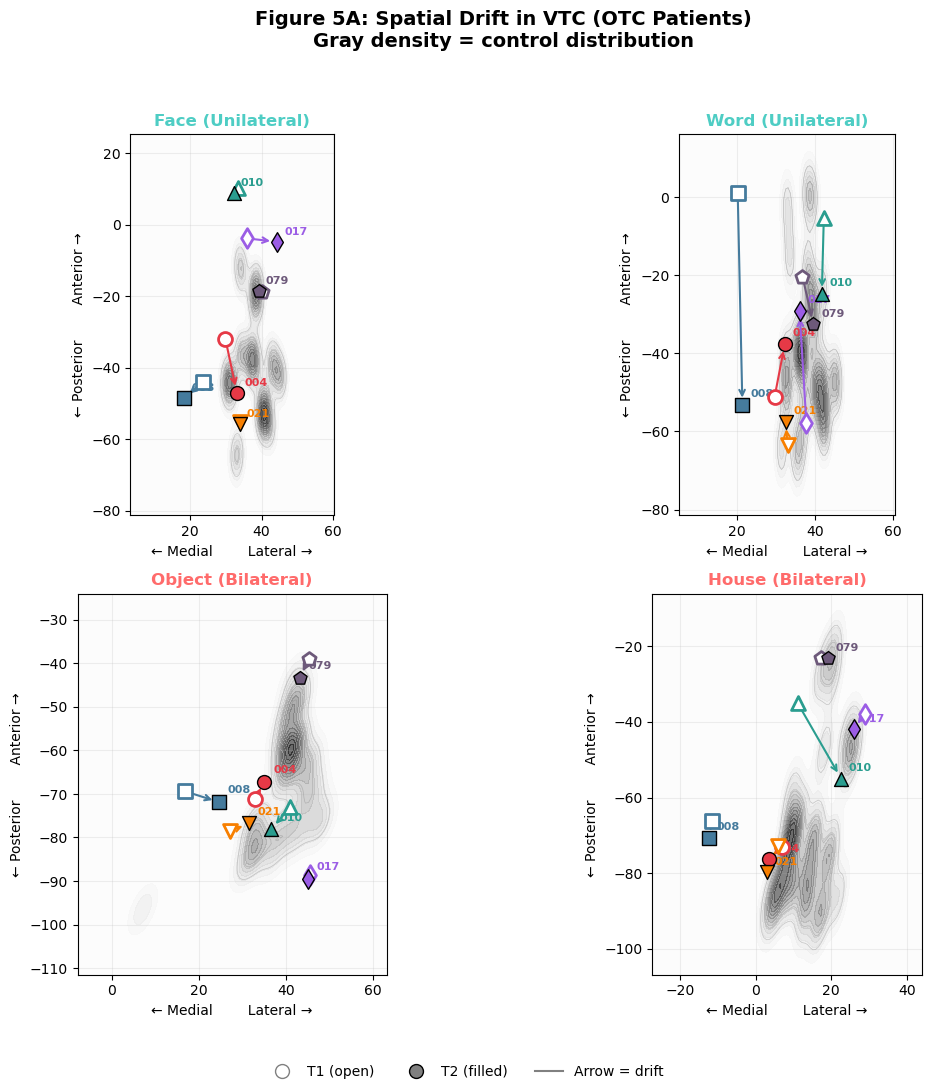


SPATIAL DRIFT SUMMARY (OTC, intact hemisphere)

Code       Category   Type         Drift (mm)   Hemi
-------------------------------------------------------
OTC004     face       Unilateral   15.4         l
OTC004     house      Bilateral    4.8          l
OTC004     object     Bilateral    4.5          l
OTC004     word       Unilateral   18.8         l
OTC008     face       Unilateral   6.8          l
OTC008     house      Bilateral    7.5          l
OTC008     object     Bilateral    12.4         l
OTC008     word       Unilateral   54.2         l
OTC010     face       Unilateral   3.9          r
OTC010     house      Bilateral    29.8         r
OTC010     object     Bilateral    6.8          r
OTC010     word       Unilateral   20.0         r
OTC017     face       Unilateral   8.5          r
OTC017     house      Bilateral    5.1          r
OTC017     object     Bilateral    1.5          r
OTC017     word       Unilateral   30.4         r
OTC021     face       Unilateral   0.8    

In [5]:
"""
Figure 5 Panel A: Ayzenberg-style 2D VTC flatmap
- Background: Control centroid density (heatmap)
- Overlay: OTC patient T1→T2 centroids with arrows
- Uses correct hemisphere for each patient
"""

# ============================================================
# PLOTTING FUNCTION
# ============================================================

def plot_ayzenberg_flatmap(centroid_df, patient_t1t2, category, ax=None, show_arrows=True):
    """
    Ayzenberg Fig 4B/5B style:
    - 2D heatmap of control centroids (Y=A-P, X=M-L)
    - Patient points overlaid with T1→T2 arrows
    - Pools both hemispheres (flips left to match right)
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    # --- Control data: pool both hemispheres ---
    ctrl = centroid_df[(centroid_df['group'] == 'control') & 
                       (centroid_df['category'] == category)].copy()
    
    # Flip left hemisphere X coords to pool with right (makes lateral = positive)
    ctrl['x_pooled'] = ctrl.apply(lambda r: -r['x'] if r['roi_hemi'] == 'l' else r['x'], axis=1)
    
    ctrl_x = ctrl['x_pooled'].values
    ctrl_y = ctrl['y'].values
    
    # --- Patient data for this category ---
    pt = patient_t1t2[patient_t1t2['category'] == category].copy()
    
    # Flip patient coords same way (left hemi → flip X)
    pt['x1_pooled'] = pt.apply(lambda r: -r['x1'] if r['roi_hemi'] == 'l' else r['x1'], axis=1)
    pt['x2_pooled'] = pt.apply(lambda r: -r['x2'] if r['roi_hemi'] == 'l' else r['x2'], axis=1)
    
    # --- Plot control density heatmap ---
    if len(ctrl_x) > 5:
        # Determine grid bounds
        all_x = np.concatenate([ctrl_x, pt['x1_pooled'].values, pt['x2_pooled'].values])
        all_y = np.concatenate([ctrl_y, pt['y1'].values, pt['y2'].values])
        
        x_pad, y_pad = 15, 15
        x_grid = np.linspace(all_x.min() - x_pad, all_x.max() + x_pad, 100)
        y_grid = np.linspace(all_y.min() - y_pad, all_y.max() + y_pad, 100)
        X, Y = np.meshgrid(x_grid, y_grid)
        
        try:
            kde = gaussian_kde(np.vstack([ctrl_x, ctrl_y]), bw_method=0.3)
            Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
            
            # Plot heatmap
            ax.contourf(X, Y, Z, levels=15, cmap='Greys', alpha=0.6)
            ax.contour(X, Y, Z, levels=5, colors='gray', alpha=0.4, linewidths=0.5)
        except Exception as e:
            print(f"  KDE failed for {category}: {e}")
            ax.scatter(ctrl_x, ctrl_y, c='gray', alpha=0.3, s=30)
    else:
        ax.scatter(ctrl_x, ctrl_y, c='gray', alpha=0.5, s=50, label='Controls')
    
    # --- Plot patient T1→T2 ---
    # Color/marker by patient
    patient_styles = {
        'OTC004': {'color': '#E63946', 'marker': 'o'},
        'OTC008': {'color': '#457B9D', 'marker': 's'},
        'OTC010': {'color': '#2A9D8F', 'marker': '^'},
        'OTC017': {'color': '#9B5DE5', 'marker': 'd'},
        'OTC021': {'color': '#F77F00', 'marker': 'v'},
        'OTC079': {'color': '#6D597A', 'marker': 'p'},
    }
    
    for _, row in pt.iterrows():
        code = row['code']
        style = patient_styles.get(code, {'color': 'black', 'marker': 'o'})
        color = style['color']
        marker = style['marker']
        
        x1, y1 = row['x1_pooled'], row['y1']
        x2, y2 = row['x2_pooled'], row['y2']
        
        # T1 point (open marker)
        ax.scatter(x1, y1, facecolors='white', edgecolors=color, 
                   s=100, marker=marker, linewidths=2, zorder=10)
        
        # T2 point (filled marker)
        ax.scatter(x2, y2, facecolors=color, edgecolors='black', 
                   s=100, marker=marker, linewidths=1, zorder=11)
        
        # Arrow T1→T2
        if show_arrows and row['drift'] > 1:  # Only show arrow if drift > 1mm
            ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                       arrowprops=dict(arrowstyle='->', color=color, lw=1.5, 
                                      shrinkA=5, shrinkB=5),
                       zorder=9)
        
        # Label
        ax.annotate(f"{code.replace('OTC', '')}", 
                   xy=(x2 + 2, y2 + 2), fontsize=8, color=color, fontweight='bold')
    
    # --- Formatting ---
    ax.set_xlabel('← Medial        Lateral →', fontsize=10)
    ax.set_ylabel('← Posterior        Anterior →', fontsize=10)
    
    cat_type = CATEGORY_TYPE[category]
    type_color = '#4ECDC4' if cat_type == 'Unilateral' else '#FF6B6B'
    ax.set_title(f'{category.capitalize()} ({cat_type})', fontsize=12, fontweight='bold', color=type_color)
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.2)
    
    return ax

# ============================================================
# CREATE FIGURE 5A
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 11))

categories = ['face', 'word', 'object', 'house']

for ax, cat in zip(axes.flat, categories):
    plot_ayzenberg_flatmap(centroid_df, otc_t1t2, cat, ax=ax)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
           markeredgecolor='gray', markersize=10, label='T1 (open)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markeredgecolor='black', markersize=10, label='T2 (filled)'),
    Line2D([0], [0], color='gray', linestyle='-', label='Arrow = drift'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10, frameon=False)

fig.suptitle('Figure 5A: Spatial Drift in VTC (OTC Patients)\nGray density = control distribution', 
             fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(OUTPUT_DIR / 'fig5a_ayzenberg_spatial_drift.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# PRINT SUMMARY
# ============================================================

print("\n" + "=" * 60)
print("SPATIAL DRIFT SUMMARY (OTC, intact hemisphere)")
print("=" * 60)
print(f"\n{'Code':<10} {'Category':<10} {'Type':<12} {'Drift (mm)':<12} {'Hemi'}")
print("-" * 55)

for _, row in otc_t1t2.sort_values(['code', 'category']).iterrows():
    print(f"{row['code']:<10} {row['category']:<10} {row['category_type']:<12} {row['drift']:<12.1f} {row['roi_hemi']}")

print("\n" + "-" * 55)
print("BY CATEGORY:")
print(otc_t1t2.groupby('category')['drift'].agg(['mean', 'std']).round(1))
print("\nBY TYPE:")
print(otc_t1t2.groupby('category_type')['drift'].agg(['mean', 'std']).round(1))

Extracted 66 drift vectors (after hemisphere filtering)

Per group:
  OTC: 18 total
    face: 4
    word: 3
    object: 6
    house: 5
  nonOTC: 21 total
    face: 3
    word: 4
    object: 7
    house: 7
  control: 27 total
    face: 6
    word: 7
    object: 7
    house: 7

OTC by hemisphere:
  Left intact: 5
  Right intact: 13


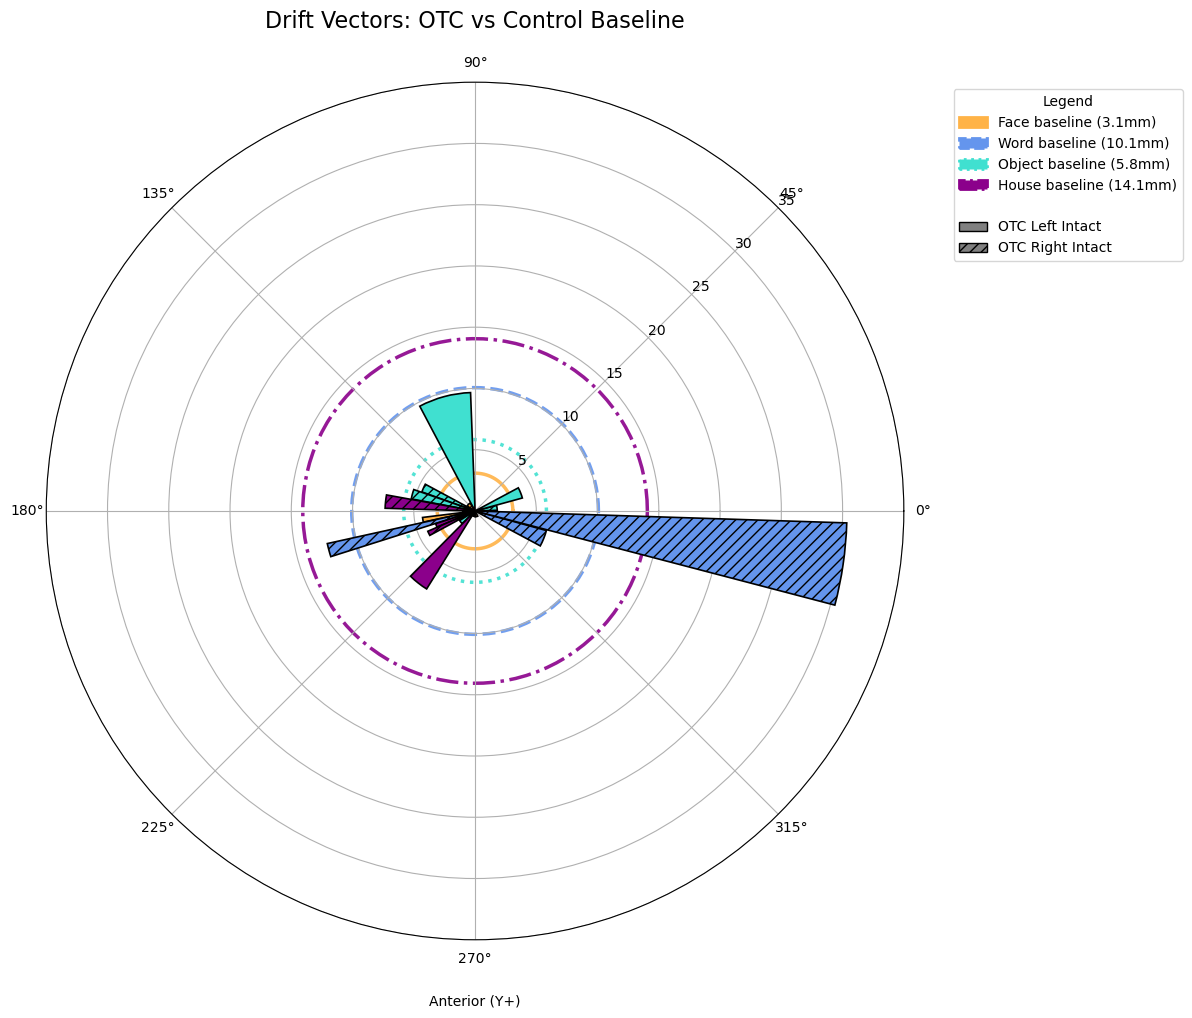

✓ Saved drift_rose_control.png


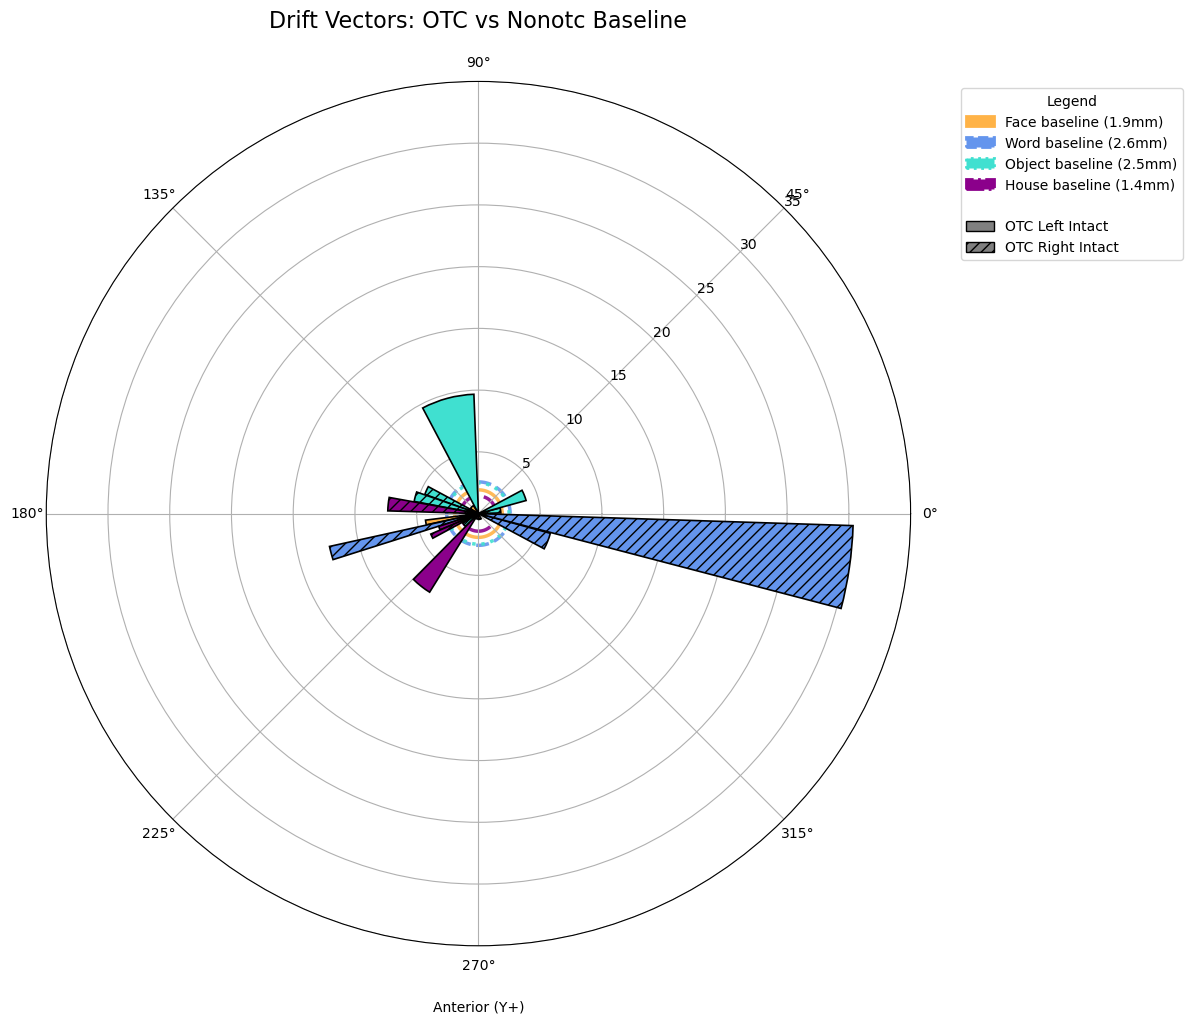

✓ Saved drift_rose_nonOTC.png


In [12]:
# CELL: Rose Plot (Balanced hemisphere selection)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

# --- CONFIGURATION ---
BIN_FILL_RATIO = 0.9 
FIGURE_DIR = '/user_data/csimmon2/git_repos/long_pt/B_analyses/figures'
random.seed(42)  # Reproducibility for control bilateral selection

colors = {
    'face': '#FFB347',    # Pastel Peach
    'word': '#6495ED',    # Cornflower Blue
    'object': '#40E0D0',  # Turquoise
    'house': '#8B008B'    # Dark Magenta
}
categories = ['face', 'word', 'object', 'house']

def cart2pol(y, z):
    return np.arctan2(z, y), np.sqrt(y**2 + z**2)

def get_bin_index(angle, bin_edges, n_bins):
    return min(np.digitize(angle, bin_edges) - 1, n_bins - 1)

def should_include_roi(roi_key, group, intact_hemi, control_bilateral_choice):
    """
    Filtering logic:
    - OTC: intact hemisphere only (already filtered by data availability)
    - nonOTC: faces=right, words=left, bilateral=intact_hemi
    - Control: faces=right, words=left, bilateral=random per subject
    """
    hemi = roi_key.split('_')[0]  # 'l' or 'r'
    cat = roi_key.split('_')[1]   # 'face', 'word', 'object', 'house'
    
    if group == 'OTC':
        # OTC: use intact hemisphere only
        return hemi == intact_hemi
    
    elif group == 'nonOTC':
        if cat == 'face':
            return hemi == 'r'
        elif cat == 'word':
            return hemi == 'l'
        else:  # object, house (bilateral)
            return hemi == intact_hemi
    
    else:  # control
        if cat == 'face':
            return hemi == 'r'
        elif cat == 'word':
            return hemi == 'l'
        else:  # object, house (bilateral)
            return hemi == control_bilateral_choice

def analyze_real_drift(results_dict, subjects_dict):
    data = []
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        group = info.get('group', 'control')
        intact_hemi = info.get('intact_hemi', None)
        
        # Random hemisphere choice for control bilateral categories (consistent per subject)
        control_bilateral_choice = random.choice(['l', 'r'])
        
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            
            # Apply filtering
            if not should_include_roi(roi_key, group, intact_hemi, control_bilateral_choice):
                continue
            
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: 
                continue
            
            s1 = sessions[sorted_ses[0]]
            s2 = sessions[sorted_ses[-1]]
            
            t1 = s1.get('threshold', s1.get('peak_z', 0))
            t2 = s2.get('threshold', s2.get('peak_z', 0))
            if t1 < 1.65 or t2 < 1.65: 
                continue
            
            c1 = s1['centroid']
            c2 = s2['centroid']
            dy = c2[1] - c1[1]
            dz = c2[2] - c1[2]
            
            angle, radius = cart2pol(dy, dz)
            
            data.append({
                'Subject': sid, 
                'Group': group, 
                'Category': cat,
                'Intact_Hemi': intact_hemi,
                'Radius': radius, 
                'Angle': angle,
                'Bin_Idx': get_bin_index(angle, bin_edges, N_BINS)
            })
            
    return pd.DataFrame(data)

def plot_rose_with_baseline(df, baseline_group='control'):
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    full_bin_width = (2 * np.pi) / N_BINS
    
    # Calculate category-specific baselines
    baseline_df = df[df['Group'] == baseline_group]
    cat_baselines = {}
    for cat in categories:
        cat_baselines[cat] = baseline_df[baseline_df['Category'] == cat]['Radius'].mean()
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
    ax.set_title(f"Drift Vectors: OTC vs {baseline_group.title()} Baseline", fontsize=16, pad=20)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlabel_position(45)
    ax.set_xlabel("Anterior (Y+)", labelpad=20)
    ax.set_ylim(0, 35)

    # Draw concentric baseline rings per category
    theta = np.linspace(0, 2*np.pi, 100)
    linestyles = ['-', '--', ':', '-.']
    for i, cat in enumerate(categories):
        baseline_val = cat_baselines[cat]
        ax.plot(theta, [baseline_val]*100, color=colors[cat], linestyle=linestyles[i], 
                linewidth=2.5, alpha=0.9, zorder=1, label=f'{cat.title()} baseline ({baseline_val:.1f}mm)')

    # Plot OTC individual bars
    otc_df = df[df['Group'] == 'OTC']
    
    for b_idx in range(N_BINS):
        bin_center = bin_centers[b_idx]
        items = otc_df[otc_df['Bin_Idx'] == b_idx].copy()
        
        if not items.empty:
            items['Cat_Sort'] = pd.Categorical(items['Category'], categories=categories, ordered=True)
            items = items.sort_values(['Cat_Sort', 'Radius'])
            
            n_items = len(items)
            total_usable_width = full_bin_width * BIN_FILL_RATIO
            individual_bar_width = total_usable_width / n_items
            cluster_start = bin_center - (total_usable_width / 2) + (individual_bar_width / 2)
            
            for k, (_, row) in enumerate(items.iterrows()):
                bar_theta = cluster_start + (k * individual_bar_width)
                hatch = None if row['Intact_Hemi'] == 'l' else '///'
                ax.bar(bar_theta, row['Radius'], width=individual_bar_width * 0.95, bottom=0.0,
                       color=colors[row['Category']], alpha=1.0, edgecolor='black', 
                       linewidth=1.2, hatch=hatch, zorder=10)

    # Build legend
    legend_cats = [mpatches.Patch(facecolor=colors[cat], edgecolor=colors[cat], linestyle=linestyles[i],
                                   linewidth=2, label=f'{cat.title()} baseline ({cat_baselines[cat]:.1f}mm)') 
                   for i, cat in enumerate(categories)]
    hemi_legend = [
        mpatches.Patch(facecolor='gray', alpha=1.0, edgecolor='black', label='OTC Left Intact'),
        mpatches.Patch(facecolor='gray', alpha=1.0, edgecolor='black', hatch='///', label='OTC Right Intact'),
    ]
    ax.legend(handles=legend_cats + [mpatches.Patch(visible=False)] + hemi_legend, 
              loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")
    
    plt.tight_layout()
    plt.savefig(f'{FIGURE_DIR}/drift_rose_{baseline_group}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved drift_rose_{baseline_group}.png")

# --- EXECUTION ---
df_drift_real = analyze_real_drift(top20_differential, ANALYSIS_SUBJECTS)

print(f"Extracted {len(df_drift_real)} drift vectors (after hemisphere filtering)")
print(f"\nPer group:")
for grp in ['OTC', 'nonOTC', 'control']:
    grp_df = df_drift_real[df_drift_real['Group'] == grp]
    print(f"  {grp}: {len(grp_df)} total")
    for cat in categories:
        n = len(grp_df[grp_df['Category'] == cat])
        print(f"    {cat}: {n}")

print(f"\nOTC by hemisphere:")
print(f"  Left intact: {len(df_drift_real[(df_drift_real['Group'] == 'OTC') & (df_drift_real['Intact_Hemi'] == 'l')])}")
print(f"  Right intact: {len(df_drift_real[(df_drift_real['Group'] == 'OTC') & (df_drift_real['Intact_Hemi'] == 'r')])}")

# Generate both plots
plot_rose_with_baseline(df_drift_real, baseline_group='control')
plot_rose_with_baseline(df_drift_real, baseline_group='nonOTC')

Extracted 66 drift vectors (after hemisphere filtering)

Per group:
  OTC: 18 total
    face: 4
    word: 3
    object: 6
    house: 5
  nonOTC: 21 total
    face: 3
    word: 4
    object: 7
    house: 7
  control: 27 total
    face: 6
    word: 7
    object: 7
    house: 7

OTC by hemisphere:
  Left intact: 5
  Right intact: 13


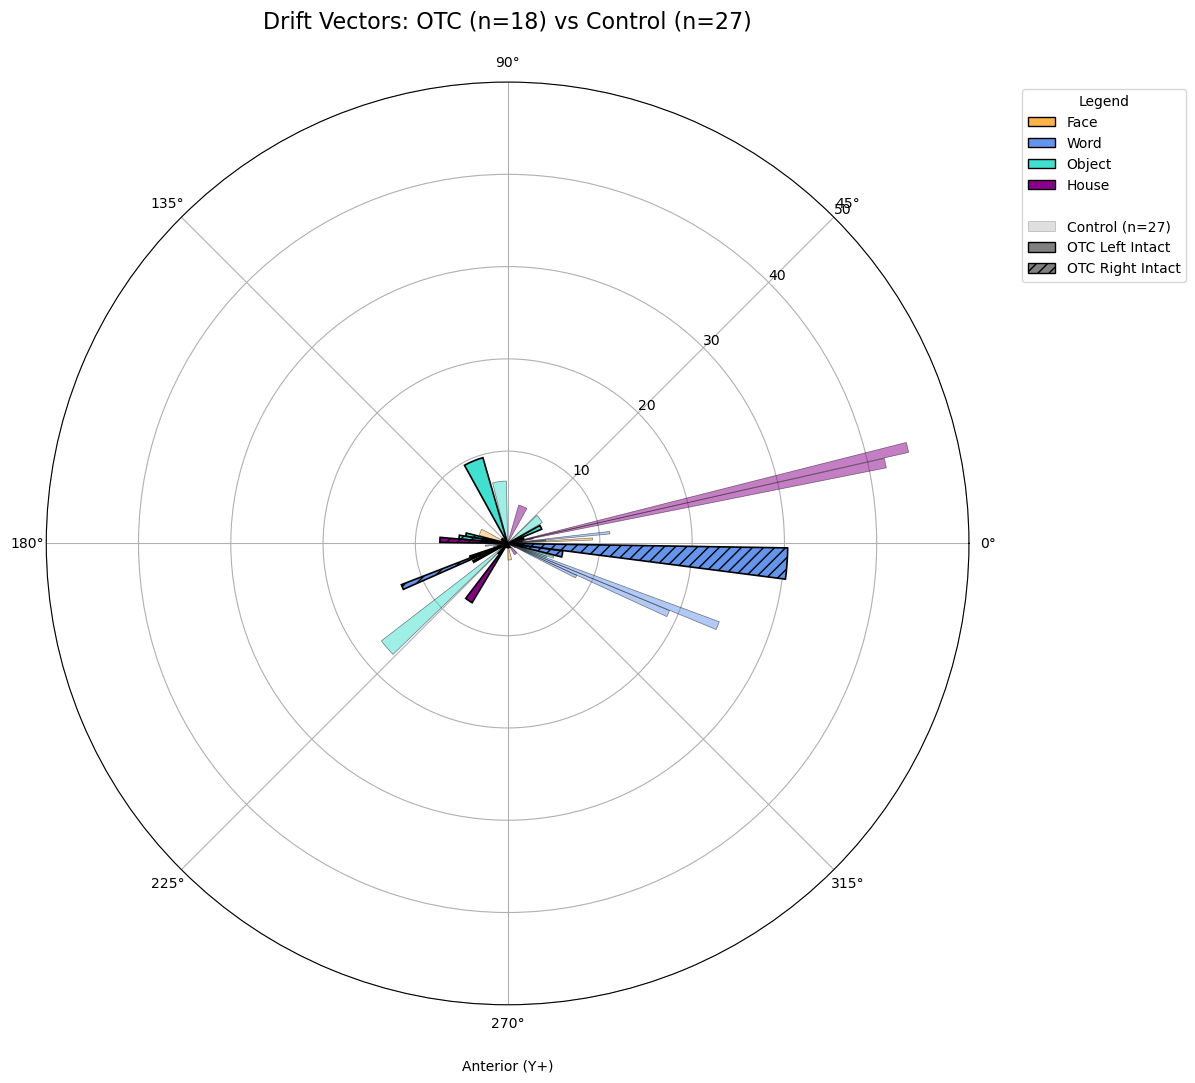

✓ Saved drift_rose_vs_control.png


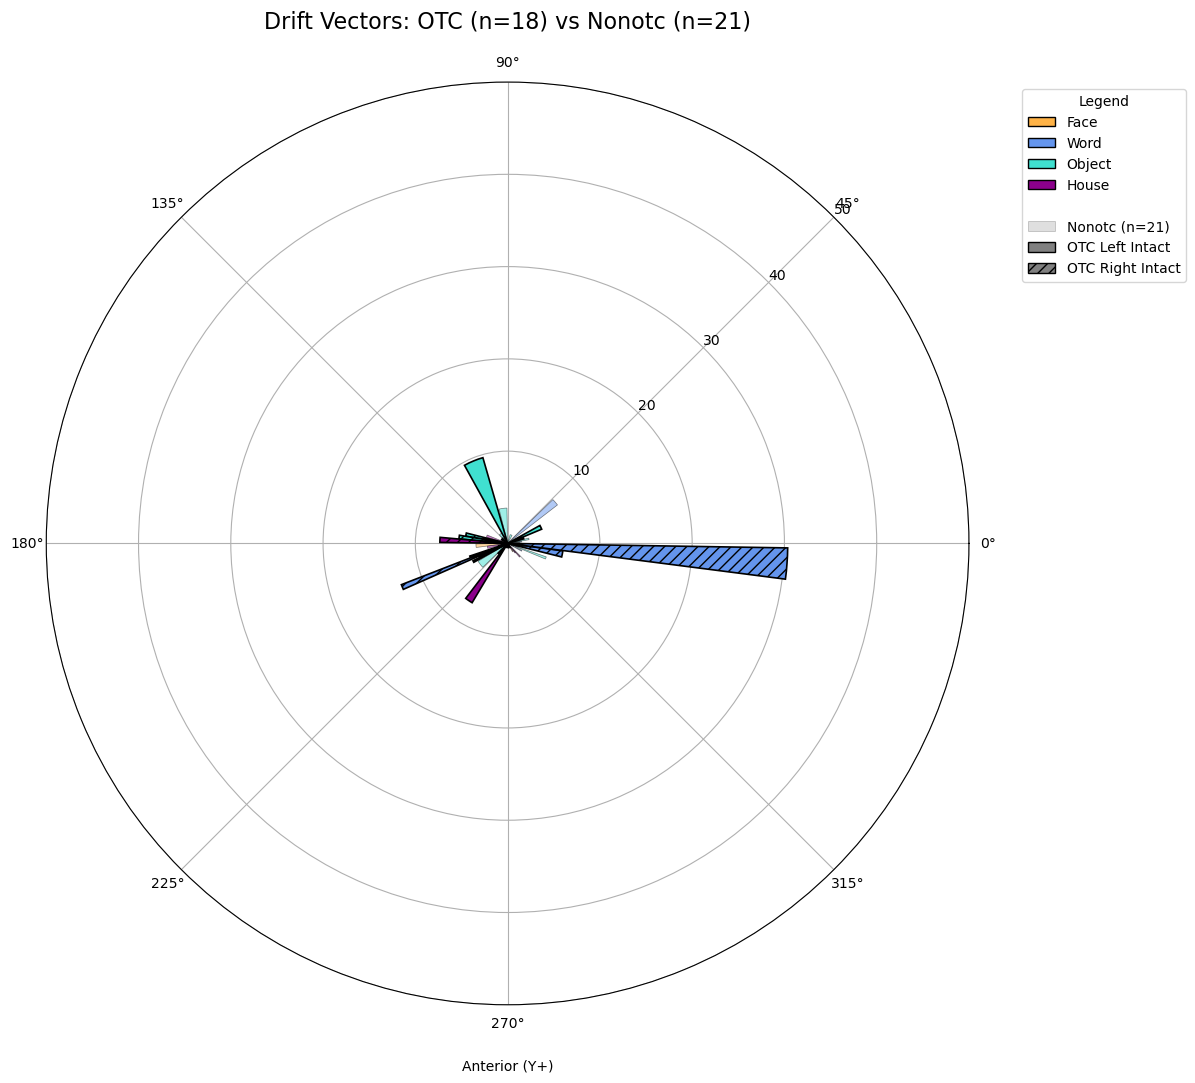

✓ Saved drift_rose_vs_nonOTC.png


In [14]:
# CELL: Rose Plot (Background group comparison)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

# --- CONFIGURATION ---
BIN_FILL_RATIO = 0.9 
FIGURE_DIR = '/user_data/csimmon2/git_repos/long_pt/B_analyses/figures'
random.seed(42)

colors = {
    'face': '#FFB347',
    'word': '#6495ED',
    'object': '#40E0D0',
    'house': '#8B008B'
}
categories = ['face', 'word', 'object', 'house']

def cart2pol(y, z):
    return np.arctan2(z, y), np.sqrt(y**2 + z**2)

def get_bin_index(angle, bin_edges, n_bins):
    return min(np.digitize(angle, bin_edges) - 1, n_bins - 1)

def should_include_roi(roi_key, group, intact_hemi, control_bilateral_choice):
    hemi = roi_key.split('_')[0]
    cat = roi_key.split('_')[1]
    
    if group == 'OTC':
        return hemi == intact_hemi
    
    elif group == 'nonOTC':
        if cat == 'face':
            return hemi == 'r'
        elif cat == 'word':
            return hemi == 'l'
        else:
            return hemi == intact_hemi
    
    else:  # control
        if cat == 'face':
            return hemi == 'r'
        elif cat == 'word':
            return hemi == 'l'
        else:
            return hemi == control_bilateral_choice

def analyze_real_drift(results_dict, subjects_dict):
    data = []
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        group = info.get('group', 'control')
        intact_hemi = info.get('intact_hemi', None)
        control_bilateral_choice = random.choice(['l', 'r'])
        
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            
            if not should_include_roi(roi_key, group, intact_hemi, control_bilateral_choice):
                continue
            
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: 
                continue
            
            s1 = sessions[sorted_ses[0]]
            s2 = sessions[sorted_ses[-1]]
            
            t1 = s1.get('threshold', s1.get('peak_z', 0))
            t2 = s2.get('threshold', s2.get('peak_z', 0))
            if t1 < 1.65 or t2 < 1.65: 
                continue
            
            c1 = s1['centroid']
            c2 = s2['centroid']
            dy = c2[1] - c1[1]
            dz = c2[2] - c1[2]
            
            angle, radius = cart2pol(dy, dz)
            
            data.append({
                'Subject': sid, 
                'Group': group, 
                'Category': cat,
                'Intact_Hemi': intact_hemi,
                'Radius': radius, 
                'Angle': angle,
                'Bin_Idx': get_bin_index(angle, bin_edges, N_BINS)
            })
            
    return pd.DataFrame(data)

def plot_rose_comparison(df, background_group='control'):
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    full_bin_width = (2 * np.pi) / N_BINS
    half_bin_width = full_bin_width / 2
    
    otc_df = df[df['Group'] == 'OTC']
    bg_df = df[df['Group'] == background_group]
    
    # Counts for legend
    otc_n = len(otc_df)
    bg_n = len(bg_df)
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
    ax.set_title(f"Drift Vectors: OTC (n={otc_n}) vs {background_group.title()} (n={bg_n})", 
                 fontsize=16, pad=20)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlabel_position(45)
    ax.set_xlabel("Anterior (Y+)", labelpad=20)
    ax.set_ylim(0, 50)

    # --- PLOT BACKGROUND GROUP (left half of each bin, 25% opacity) ---
    for b_idx in range(N_BINS):
        bin_center = bin_centers[b_idx]
        left_center = bin_center - (half_bin_width / 2)
        
        items = bg_df[bg_df['Bin_Idx'] == b_idx].copy()
        
        if not items.empty:
            items['Cat_Sort'] = pd.Categorical(items['Category'], categories=categories, ordered=True)
            items = items.sort_values(['Cat_Sort', 'Radius'])
            
            n_items = len(items)
            usable_width = half_bin_width * BIN_FILL_RATIO
            bar_width = usable_width / n_items
            cluster_start = left_center - (usable_width / 2) + (bar_width / 2)
            
            for k, (_, row) in enumerate(items.iterrows()):
                bar_theta = cluster_start + (k * bar_width)
                ax.bar(bar_theta, row['Radius'], width=bar_width * 0.95, bottom=0.0,
                       color=colors[row['Category']], alpha=0.50, edgecolor='black', 
                       linewidth=0.5, zorder=5)

    # --- PLOT OTC (right half of each bin, full opacity) ---
    for b_idx in range(N_BINS):
        bin_center = bin_centers[b_idx]
        right_center = bin_center + (half_bin_width / 2)
        
        items = otc_df[otc_df['Bin_Idx'] == b_idx].copy()
        
        if not items.empty:
            items['Cat_Sort'] = pd.Categorical(items['Category'], categories=categories, ordered=True)
            items = items.sort_values(['Cat_Sort', 'Radius'])
            
            n_items = len(items)
            usable_width = half_bin_width * BIN_FILL_RATIO
            bar_width = usable_width / n_items
            cluster_start = right_center - (usable_width / 2) + (bar_width / 2)
            
            for k, (_, row) in enumerate(items.iterrows()):
                bar_theta = cluster_start + (k * bar_width)
                hatch = None if row['Intact_Hemi'] == 'l' else '///'
                ax.bar(bar_theta, row['Radius'], width=bar_width * 0.95, bottom=0.0,
                       color=colors[row['Category']], alpha=1.0, edgecolor='black', 
                       linewidth=1.2, hatch=hatch, zorder=10)

    # Build legend
    legend_cats = [mpatches.Patch(facecolor=colors[cat], edgecolor='black', 
                                   label=f'{cat.title()}') 
                   for cat in categories]
    
    group_legend = [
        mpatches.Patch(facecolor='gray', alpha=0.25, edgecolor='black', linewidth=0.5,
                       label=f'{background_group.title()} (n={bg_n})'),
        mpatches.Patch(facecolor='gray', alpha=1.0, edgecolor='black', 
                       label=f'OTC Left Intact'),
        mpatches.Patch(facecolor='gray', alpha=1.0, edgecolor='black', hatch='///',
                       label=f'OTC Right Intact'),
    ]
    
    ax.legend(handles=legend_cats + [mpatches.Patch(visible=False)] + group_legend, 
              loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")
    
    plt.tight_layout()
    plt.savefig(f'{FIGURE_DIR}/drift_rose_vs_{background_group}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved drift_rose_vs_{background_group}.png")

# --- EXECUTION ---
df_drift_real = analyze_real_drift(top20_differential, ANALYSIS_SUBJECTS)

print(f"Extracted {len(df_drift_real)} drift vectors (after hemisphere filtering)")
print(f"\nPer group:")
for grp in ['OTC', 'nonOTC', 'control']:
    grp_df = df_drift_real[df_drift_real['Group'] == grp]
    print(f"  {grp}: {len(grp_df)} total")
    for cat in categories:
        n = len(grp_df[grp_df['Category'] == cat])
        print(f"    {cat}: {n}")

print(f"\nOTC by hemisphere:")
print(f"  Left intact: {len(df_drift_real[(df_drift_real['Group'] == 'OTC') & (df_drift_real['Intact_Hemi'] == 'l')])}")
print(f"  Right intact: {len(df_drift_real[(df_drift_real['Group'] == 'OTC') & (df_drift_real['Intact_Hemi'] == 'r')])}")

# Generate both plots
plot_rose_comparison(df_drift_real, background_group='control')
plot_rose_comparison(df_drift_real, background_group='nonOTC')